C:\Users\Joy\AppData\Local\Temp\ipykernel_16536\4070072193.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace("Nan", np.nan, inplace=True)


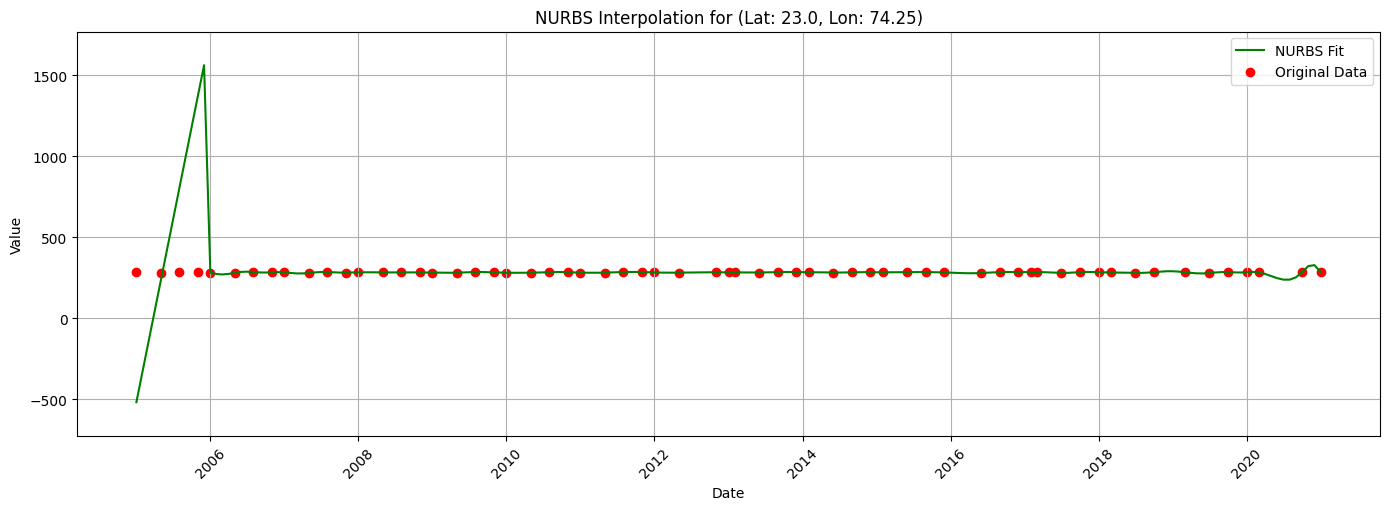

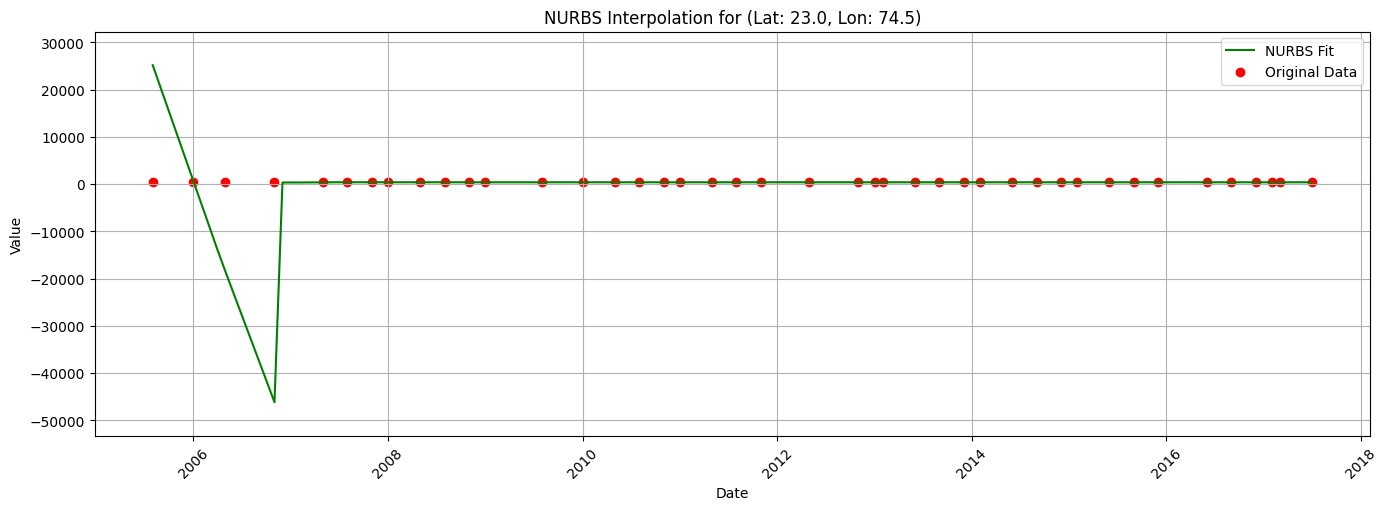

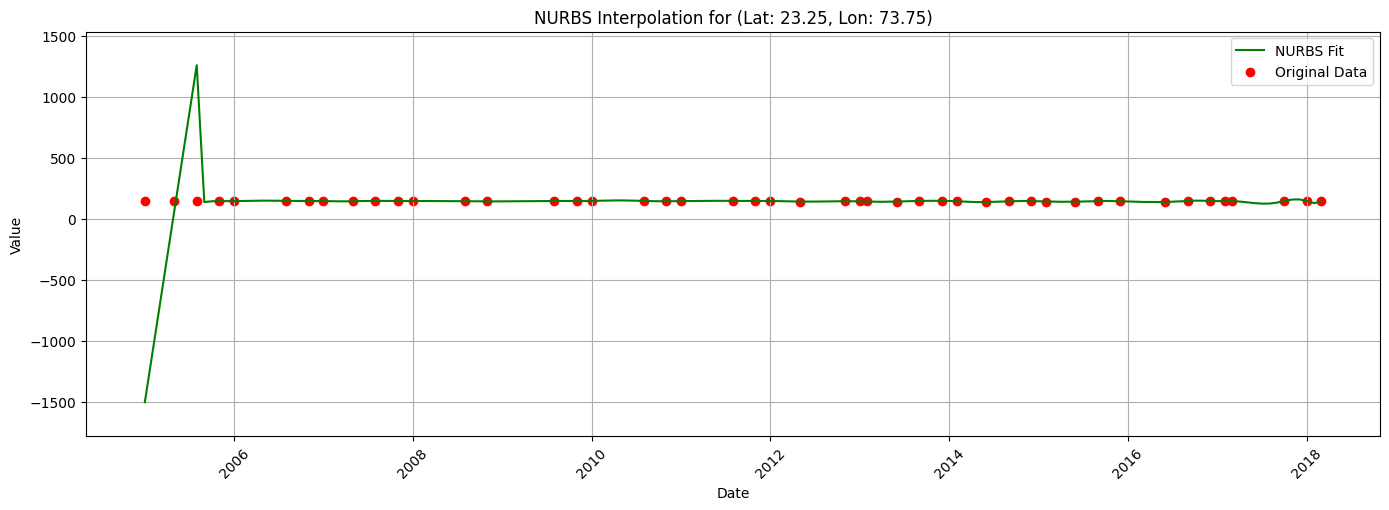

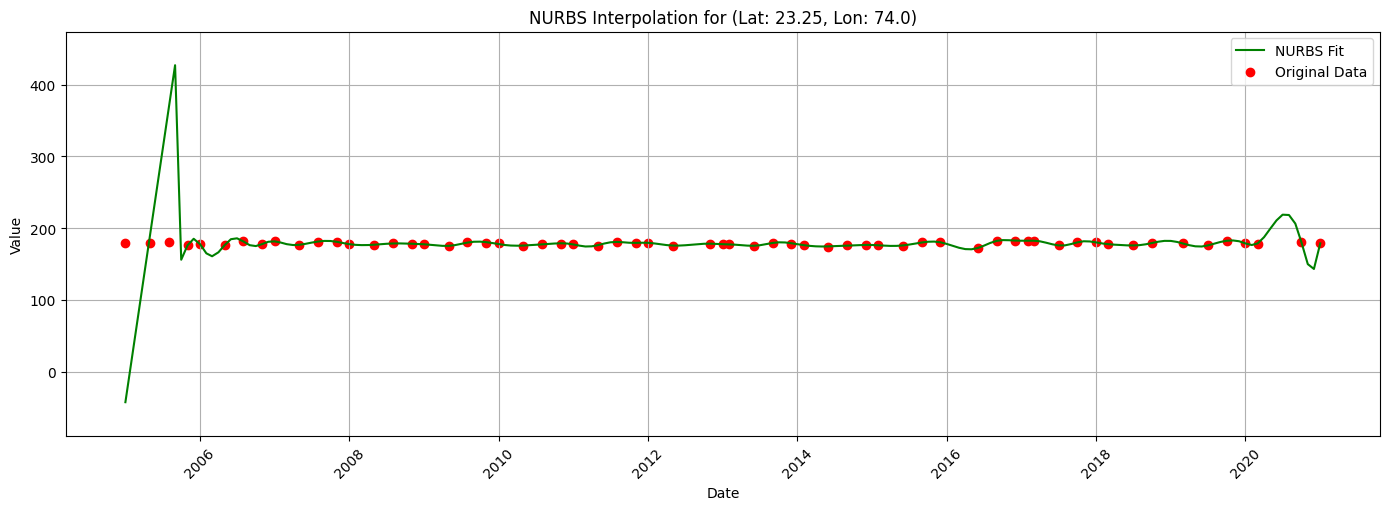

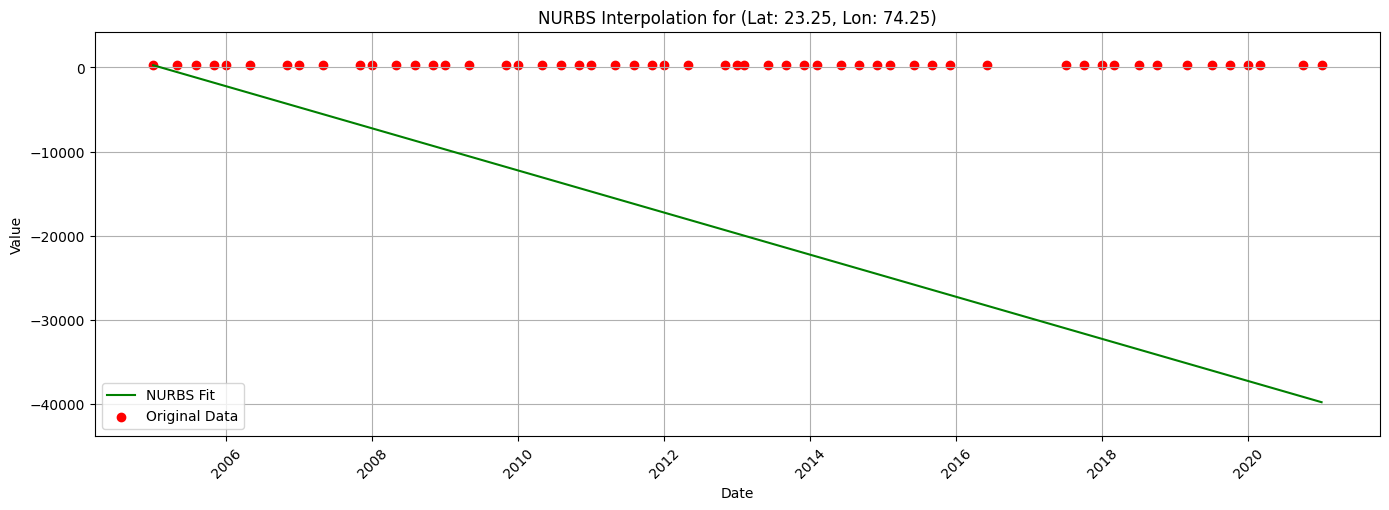

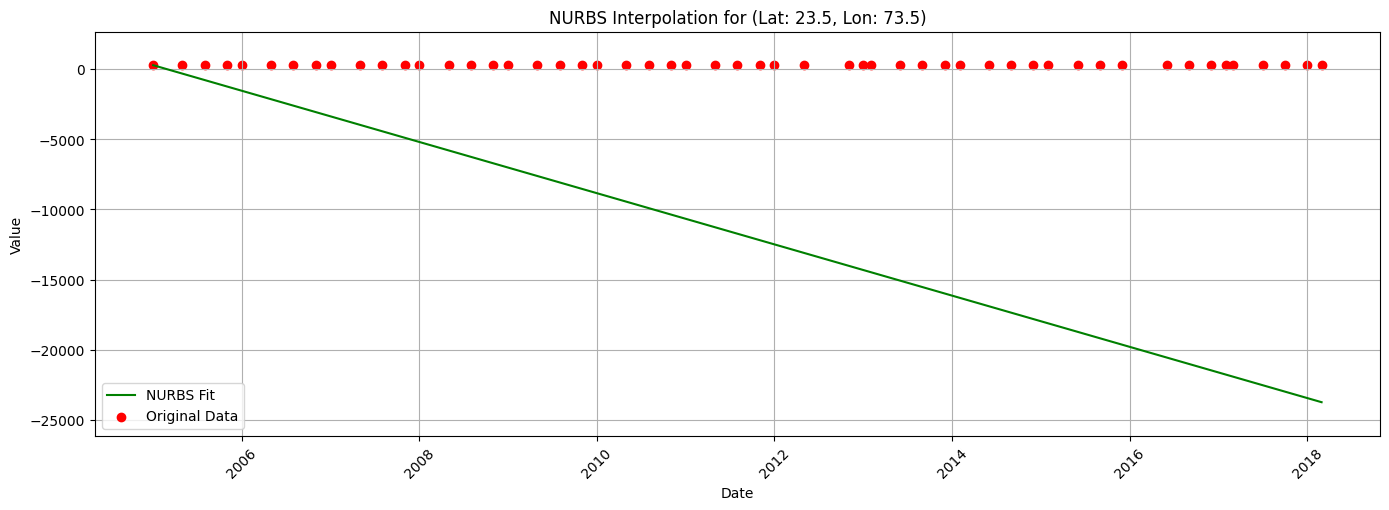

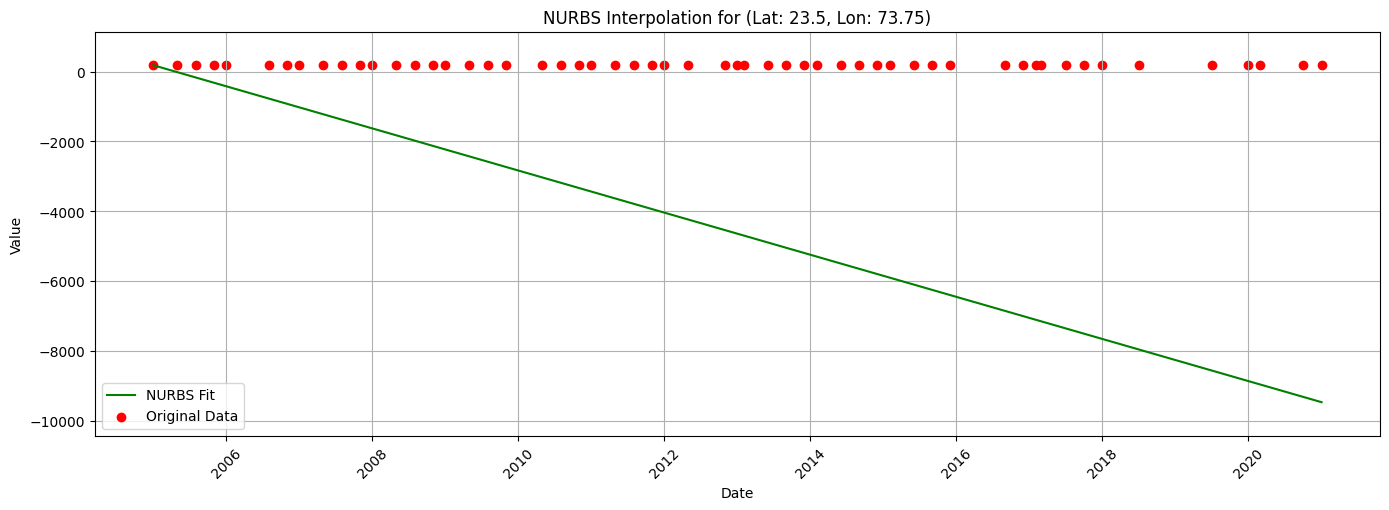

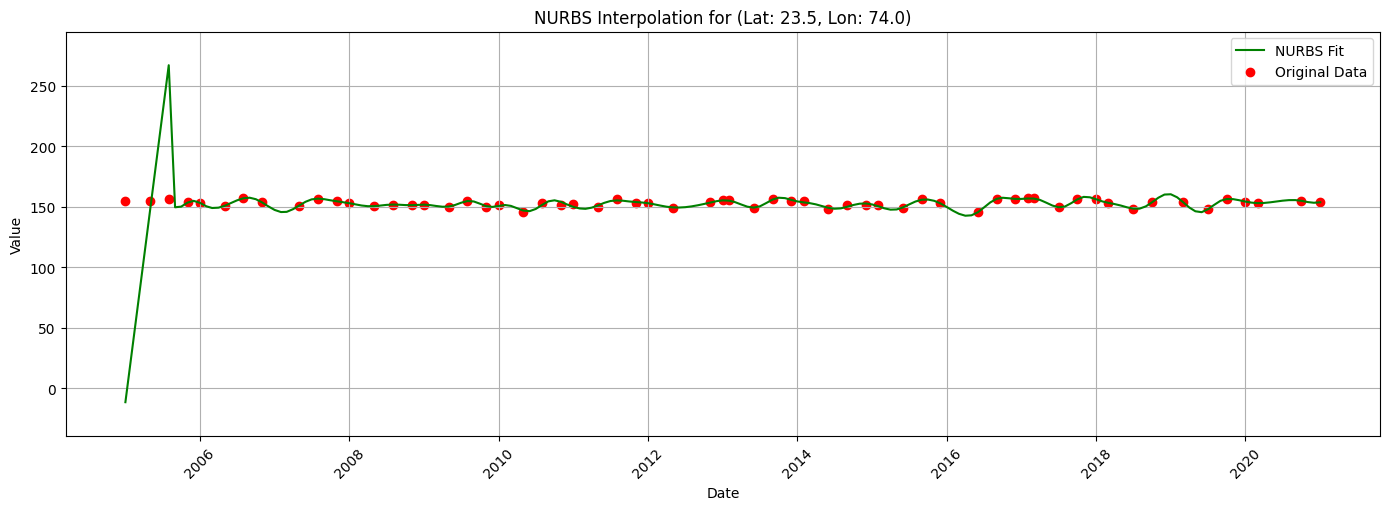

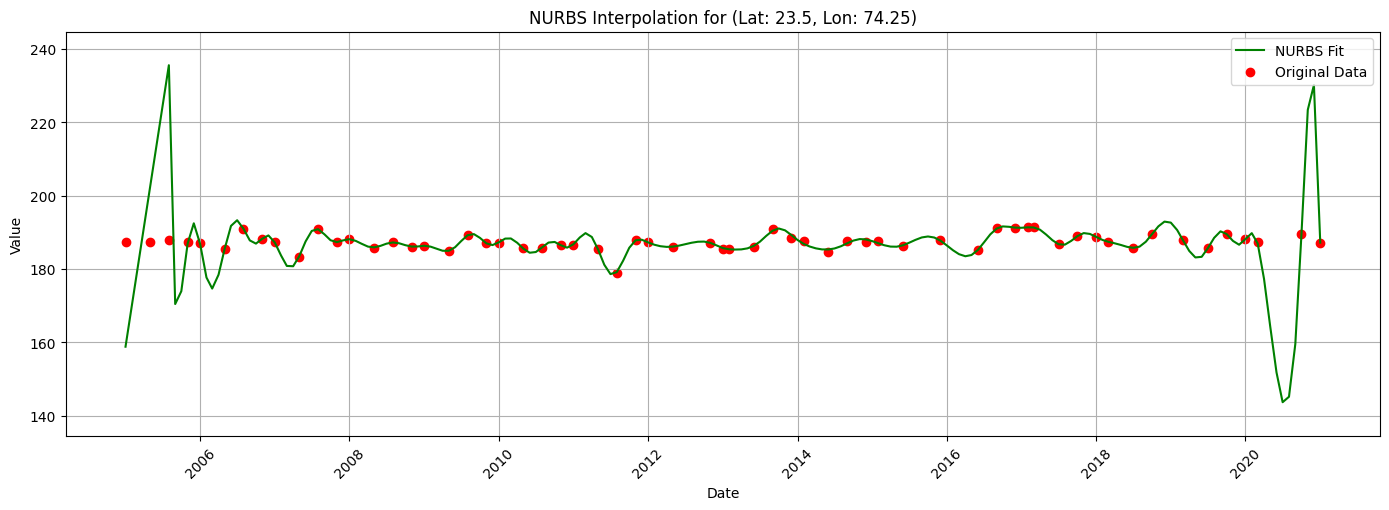

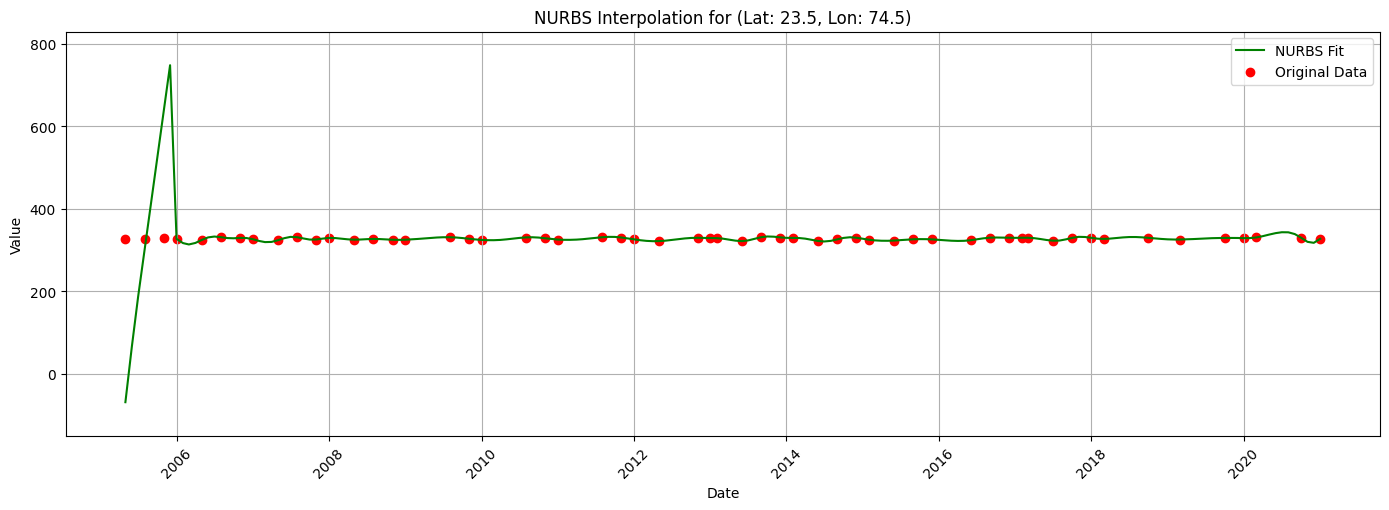

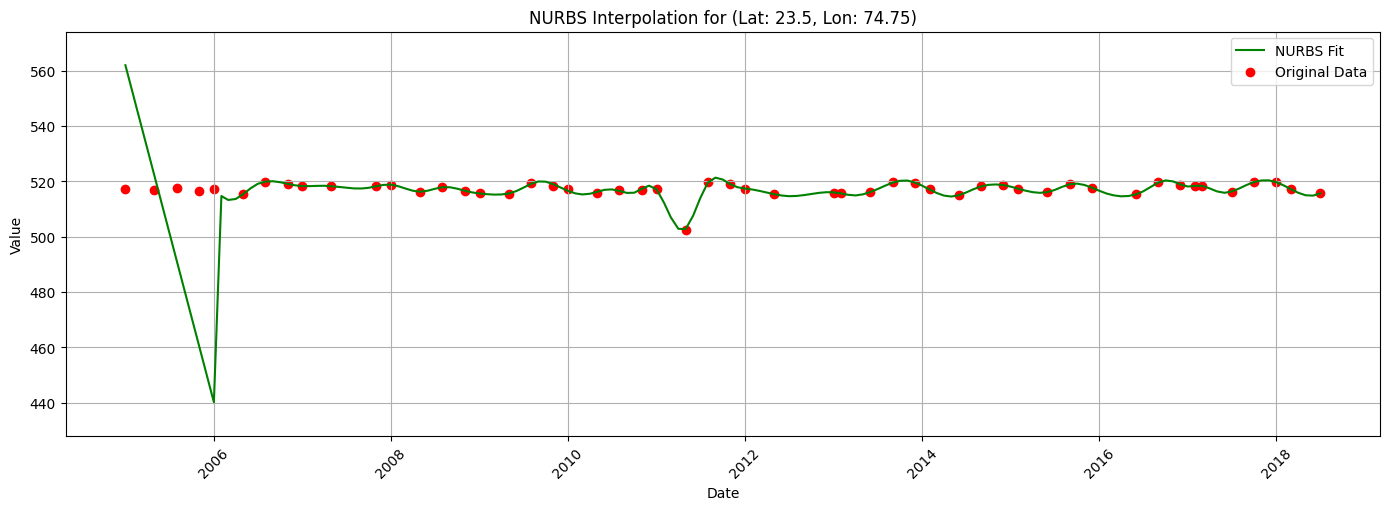

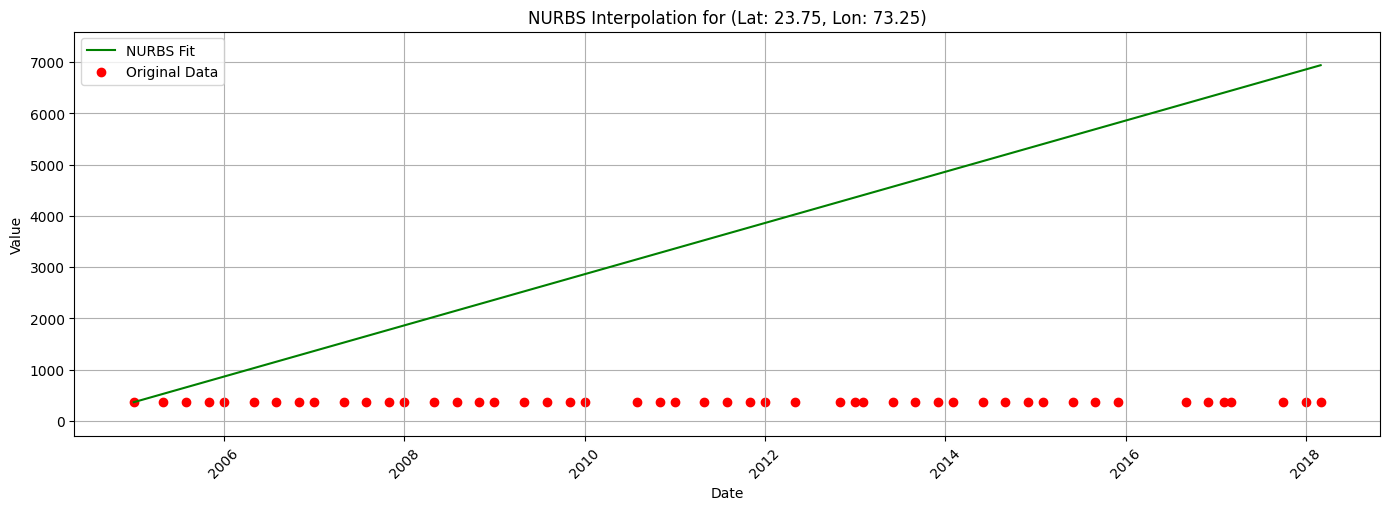

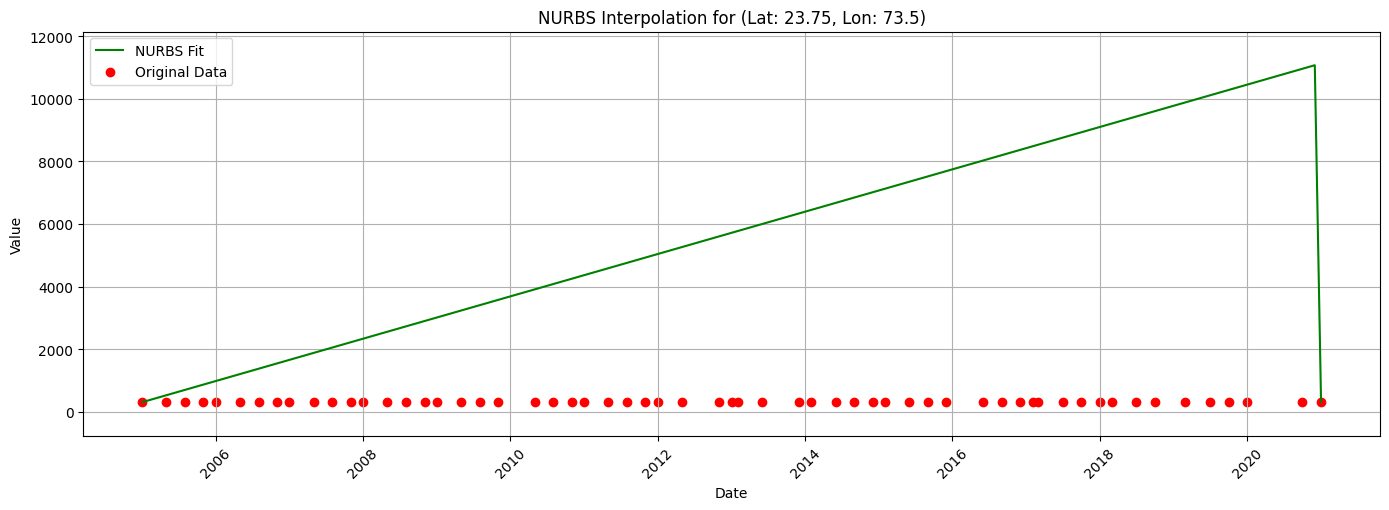

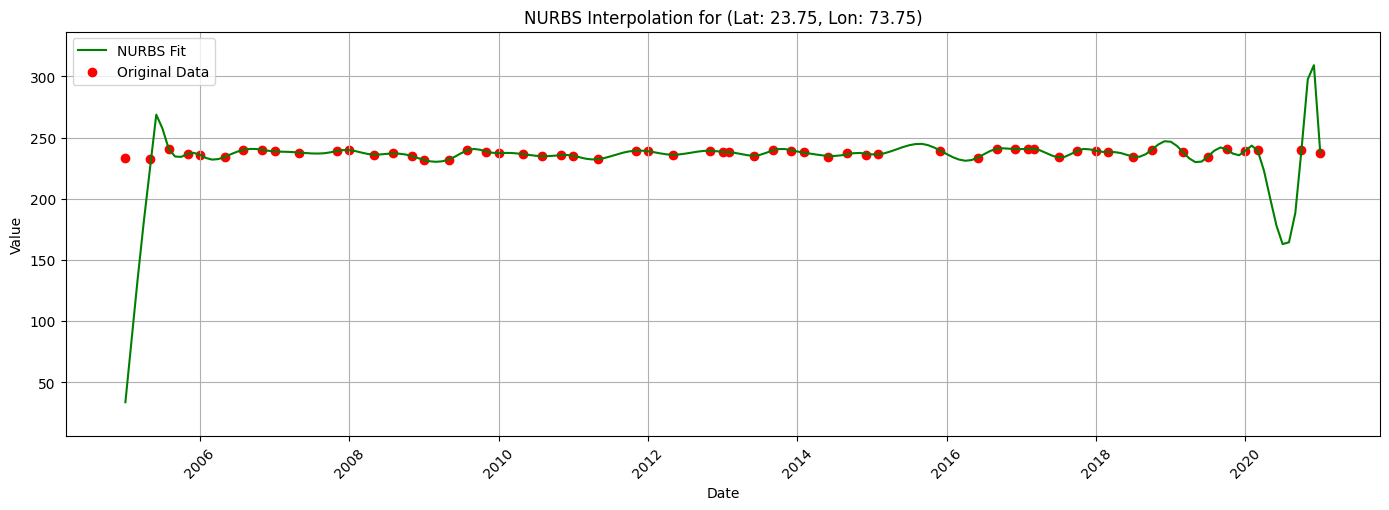

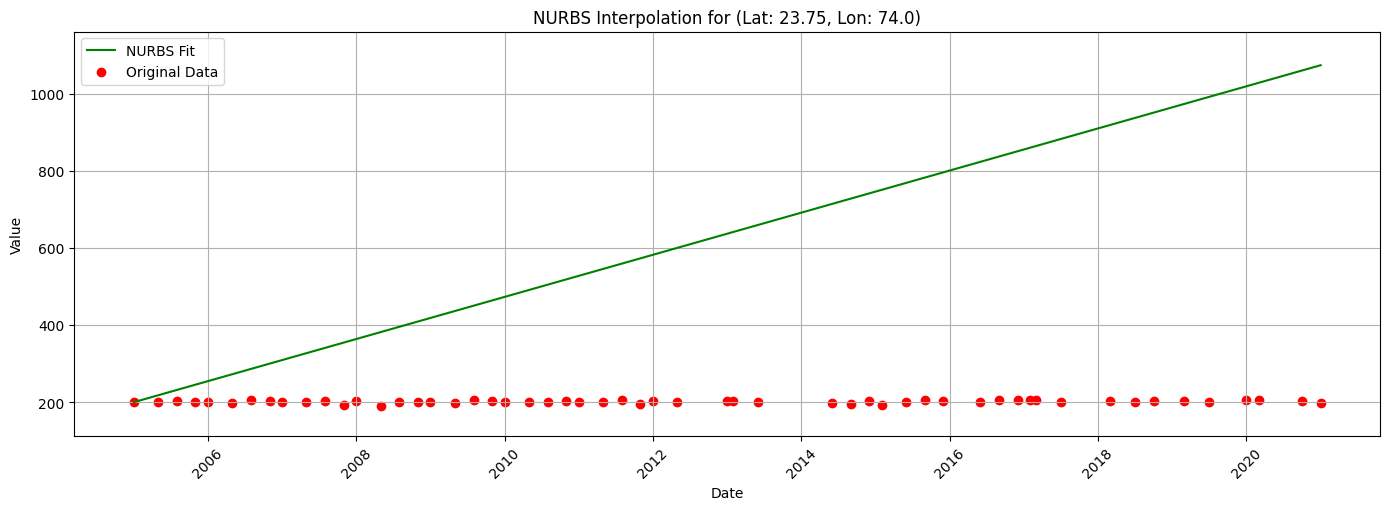

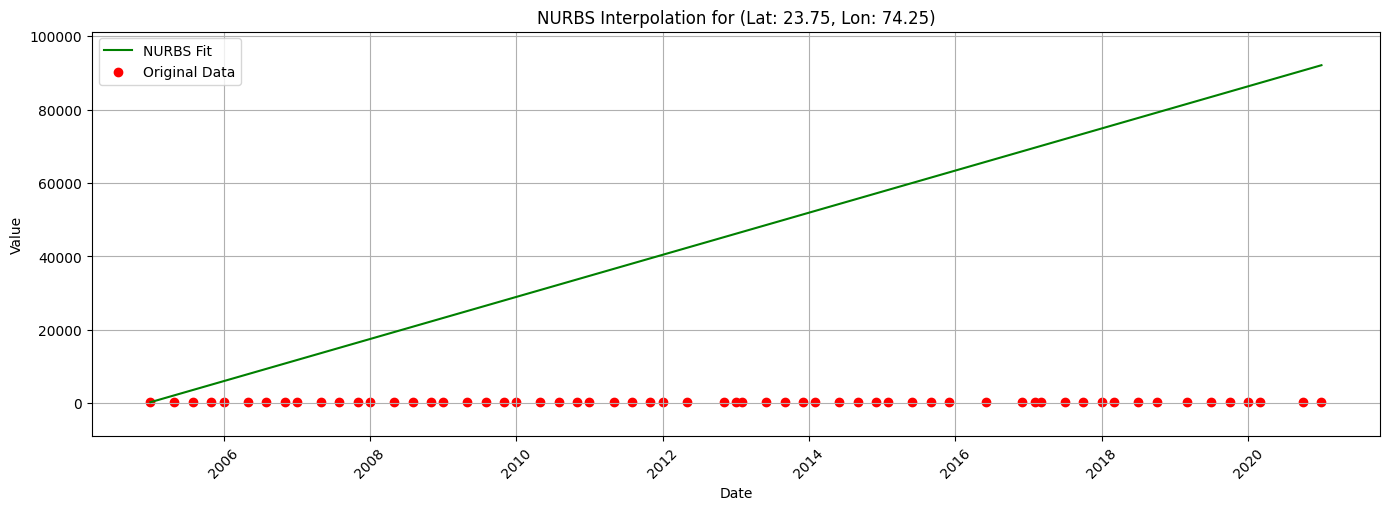

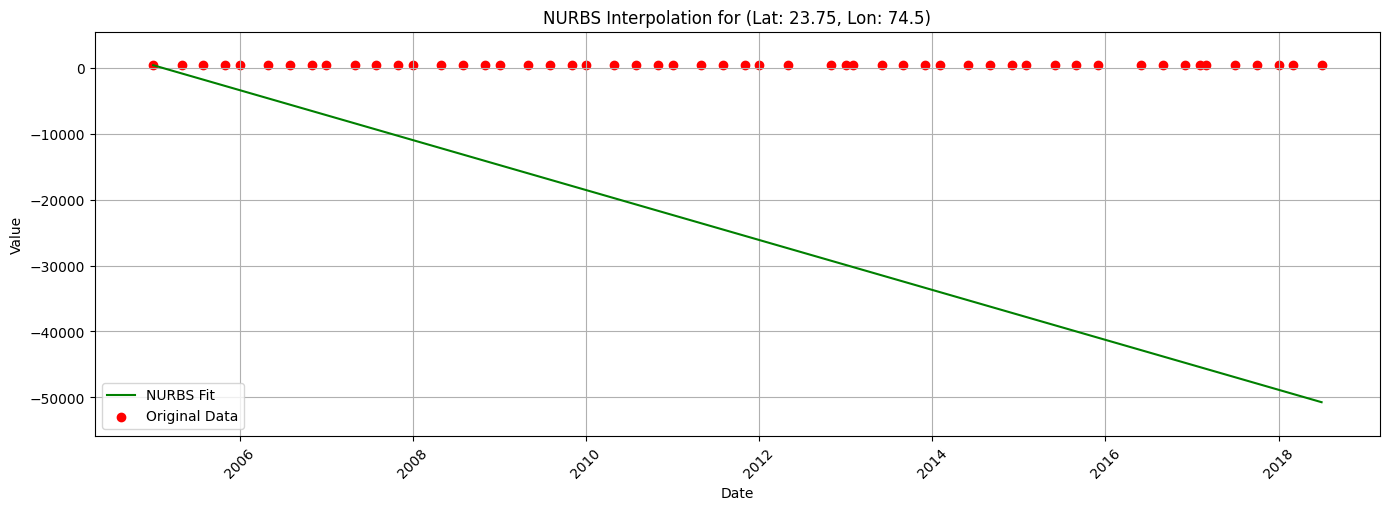

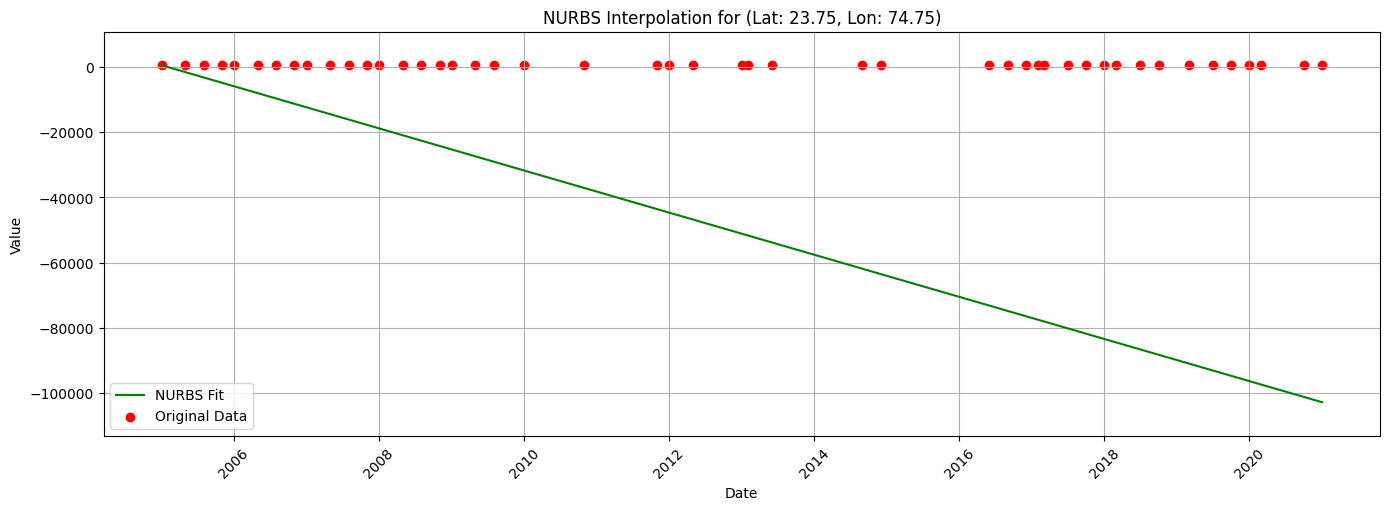

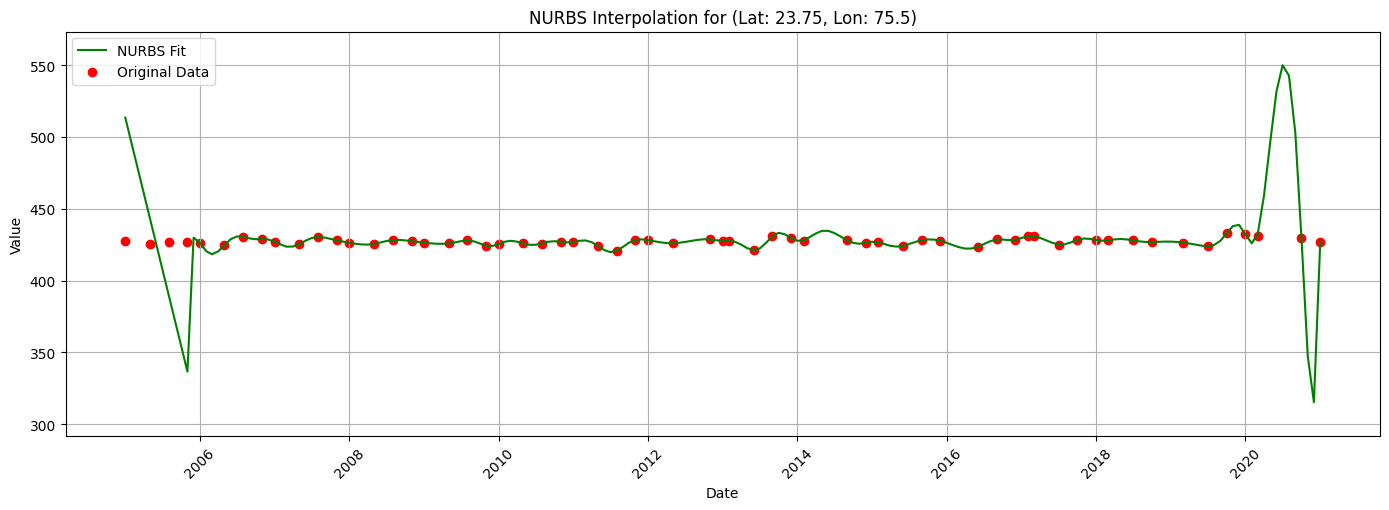

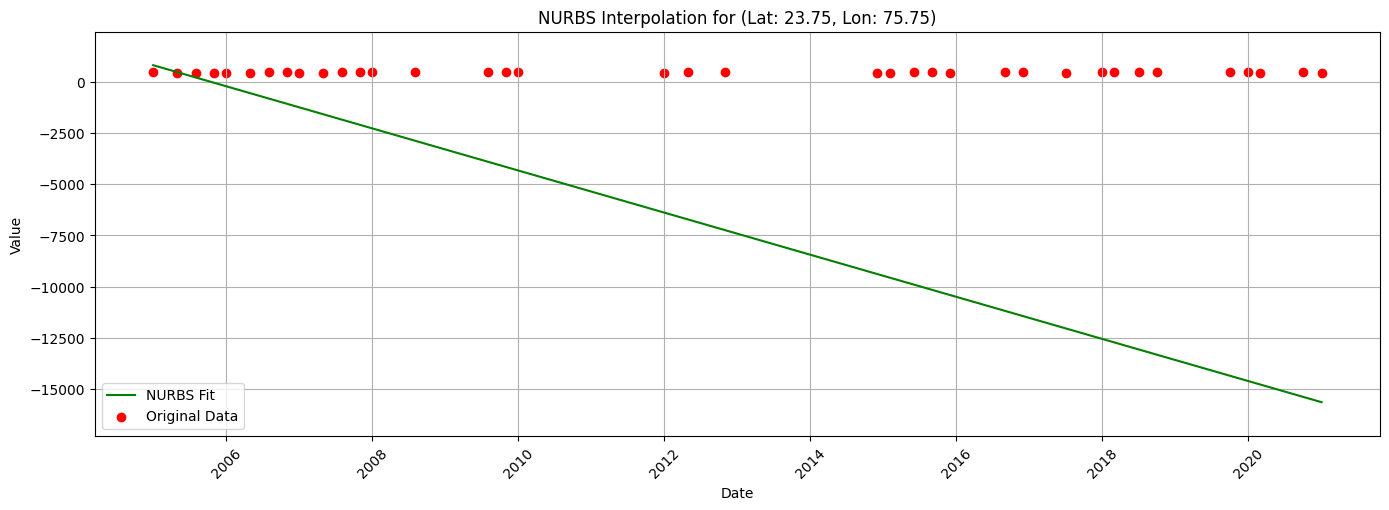

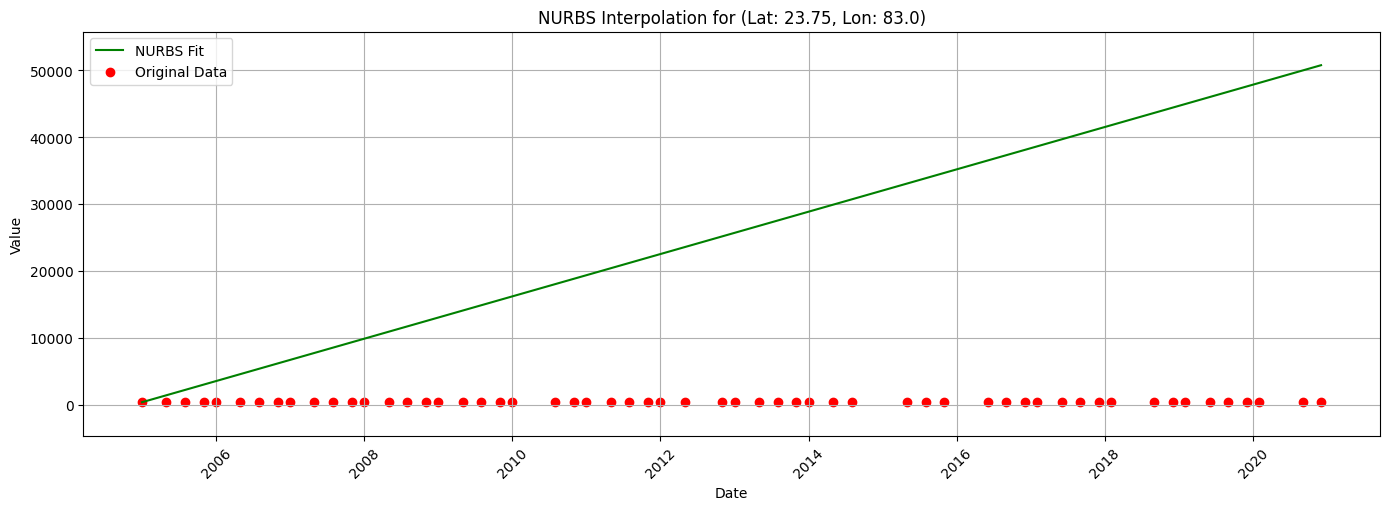

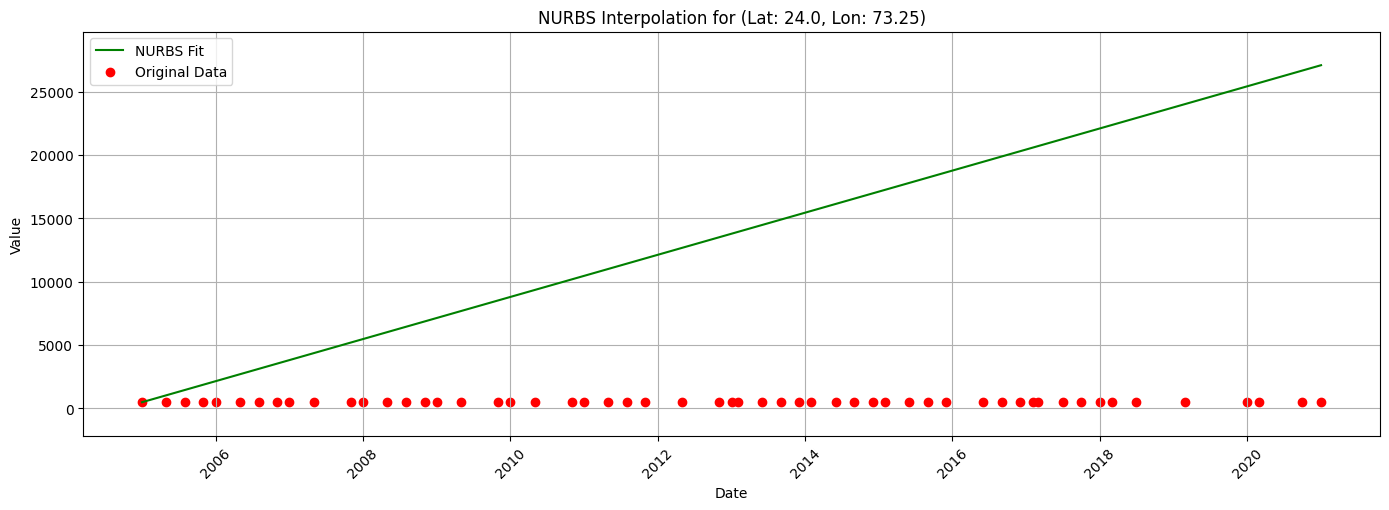

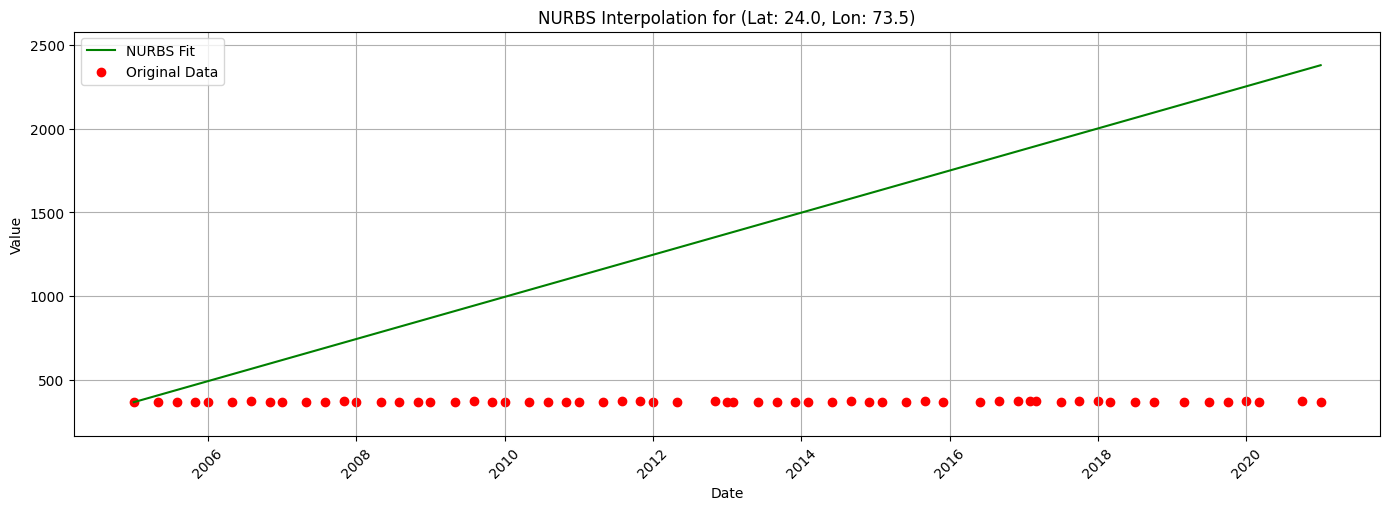

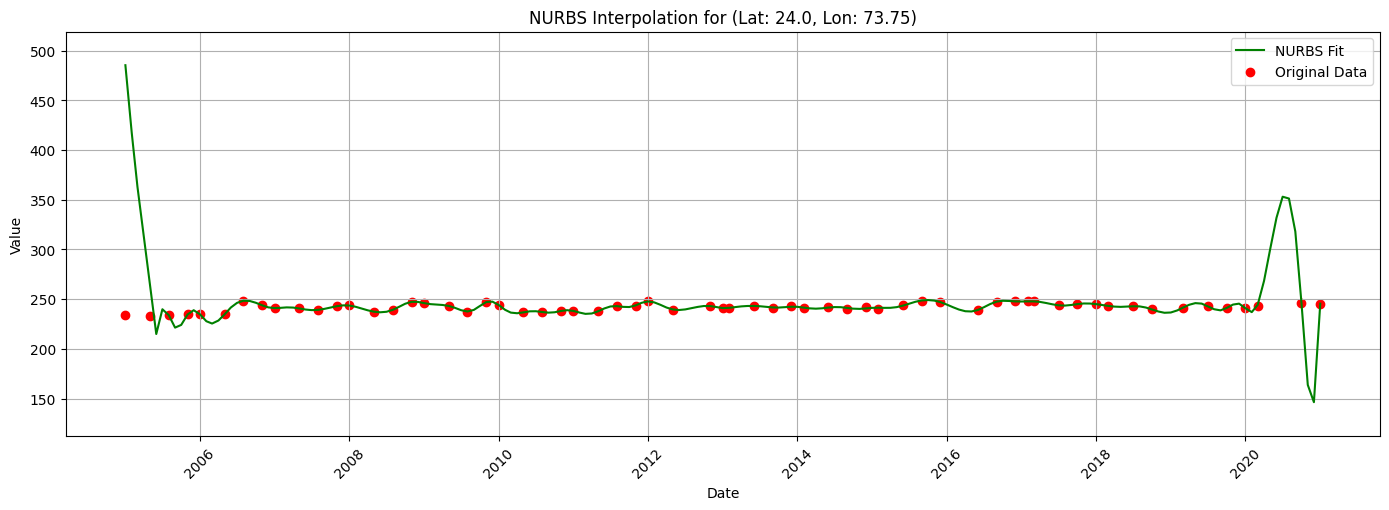

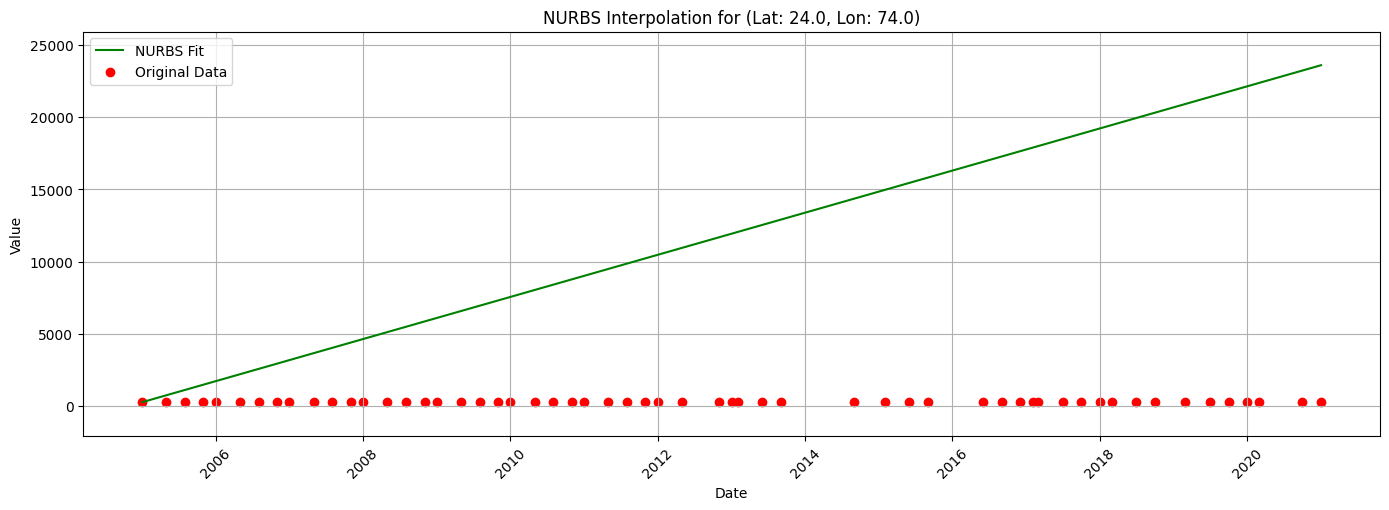

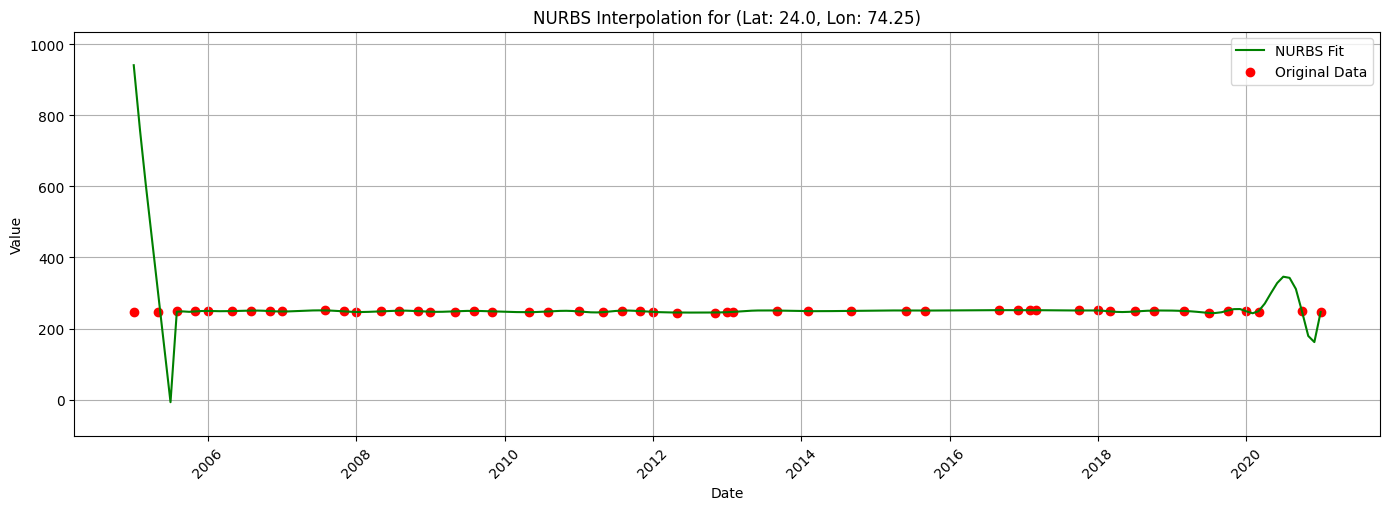

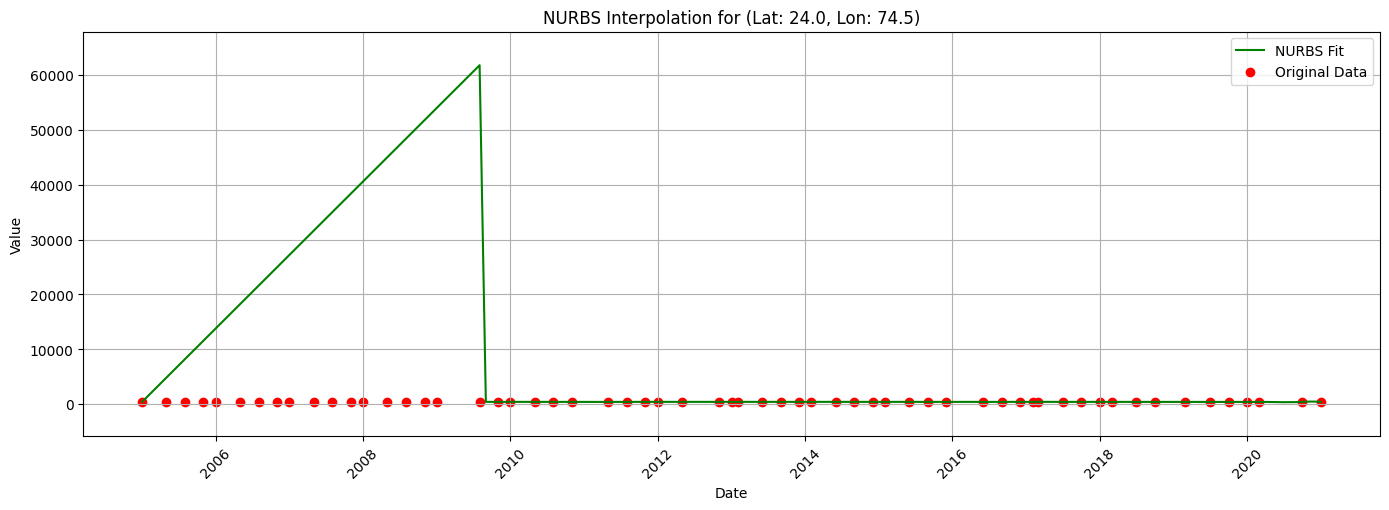

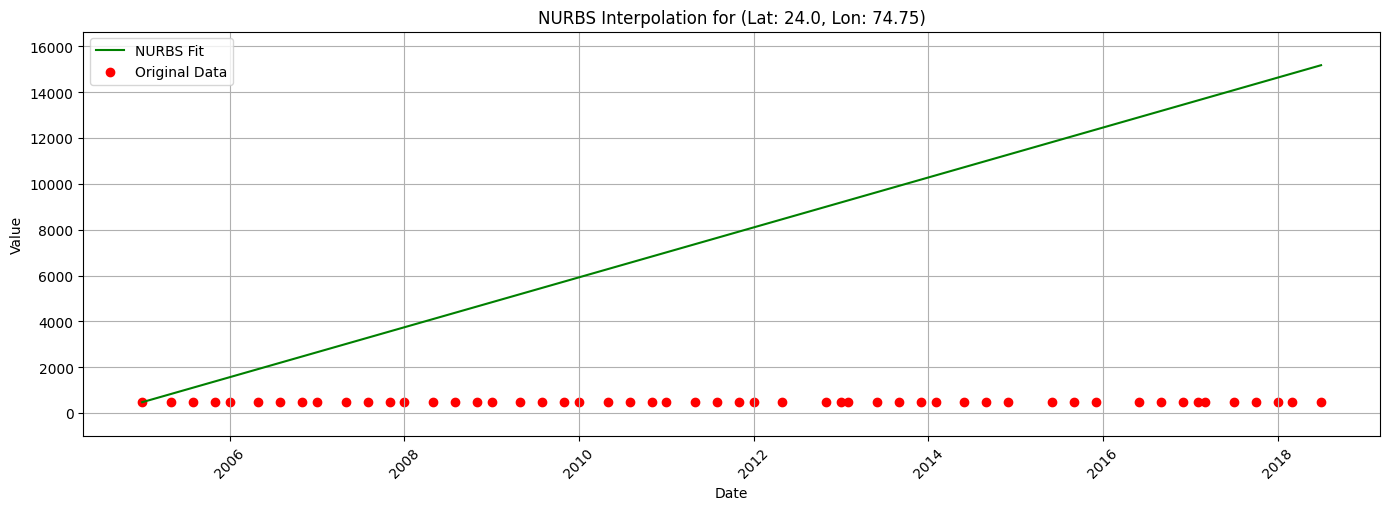

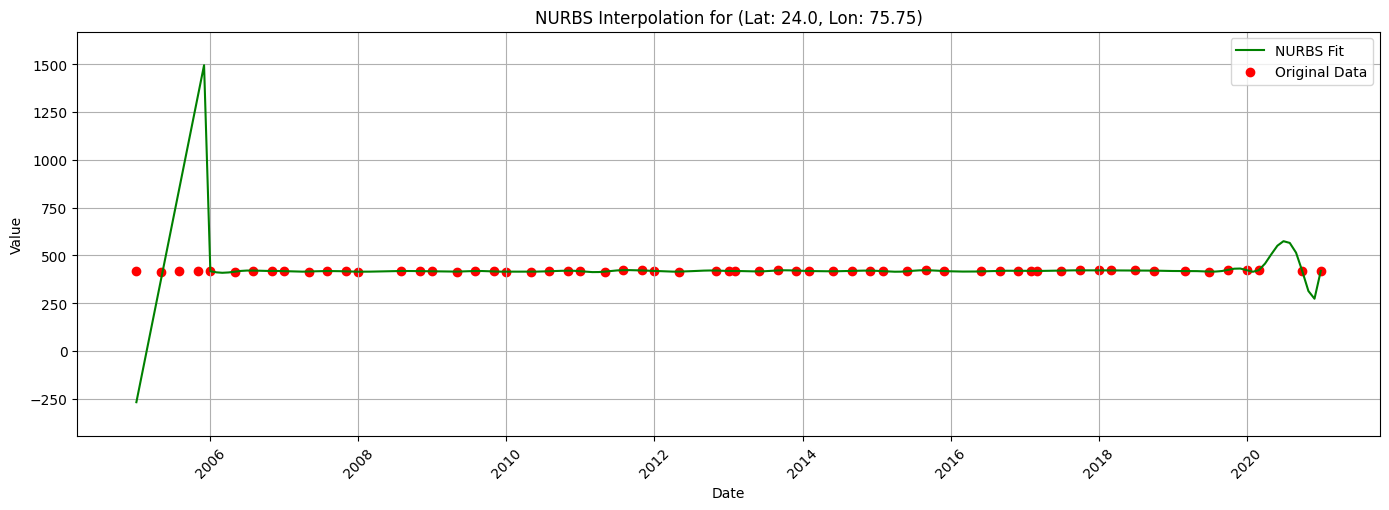

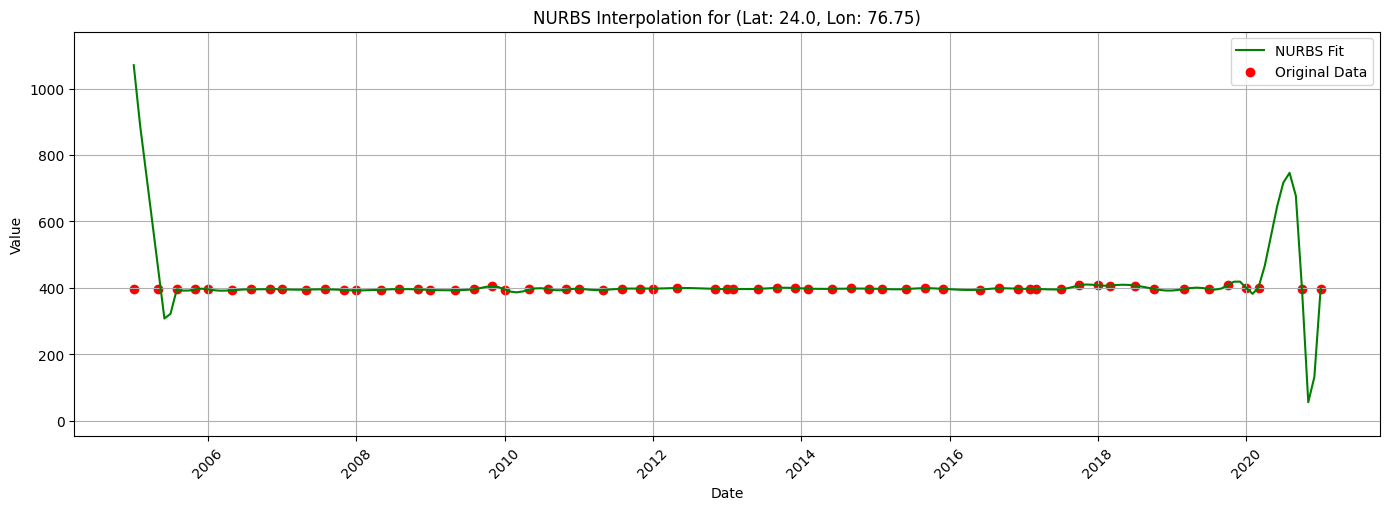

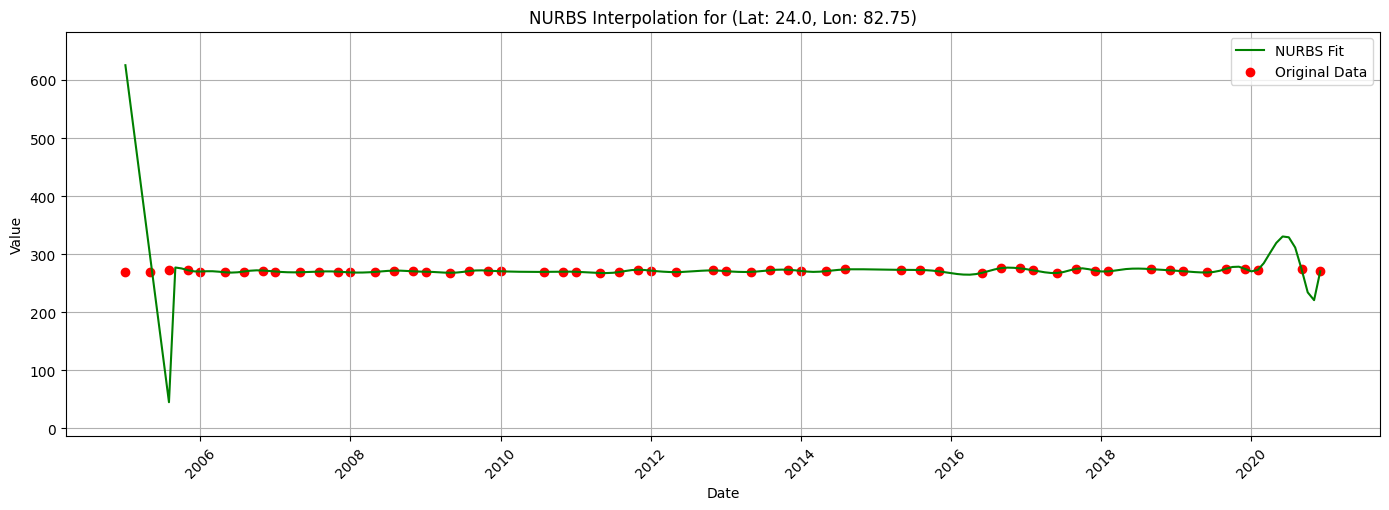

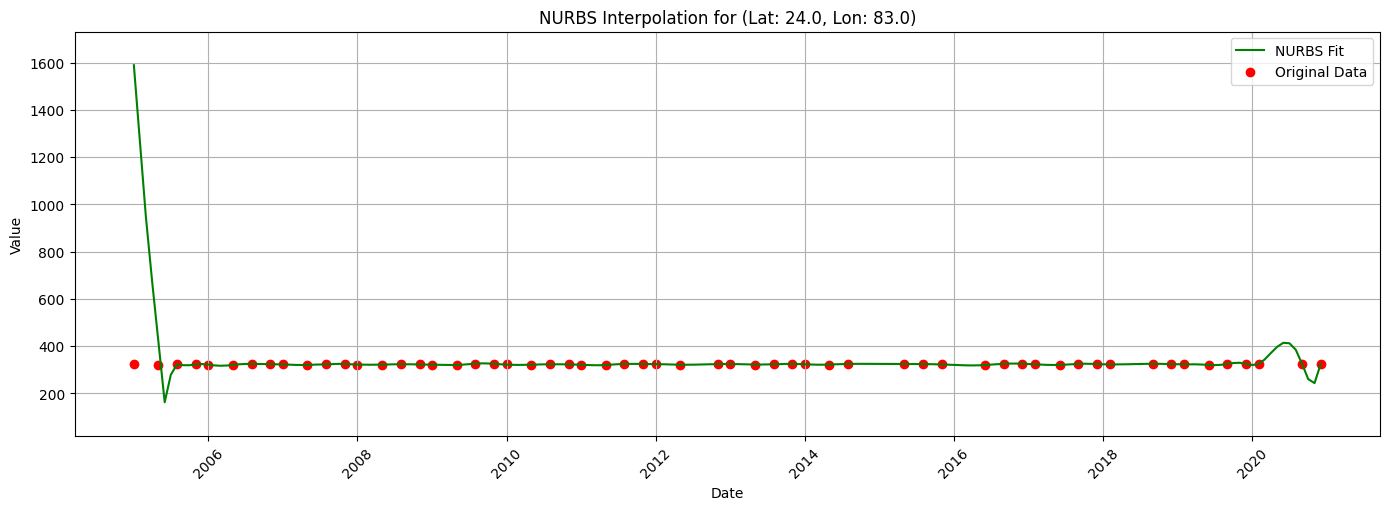

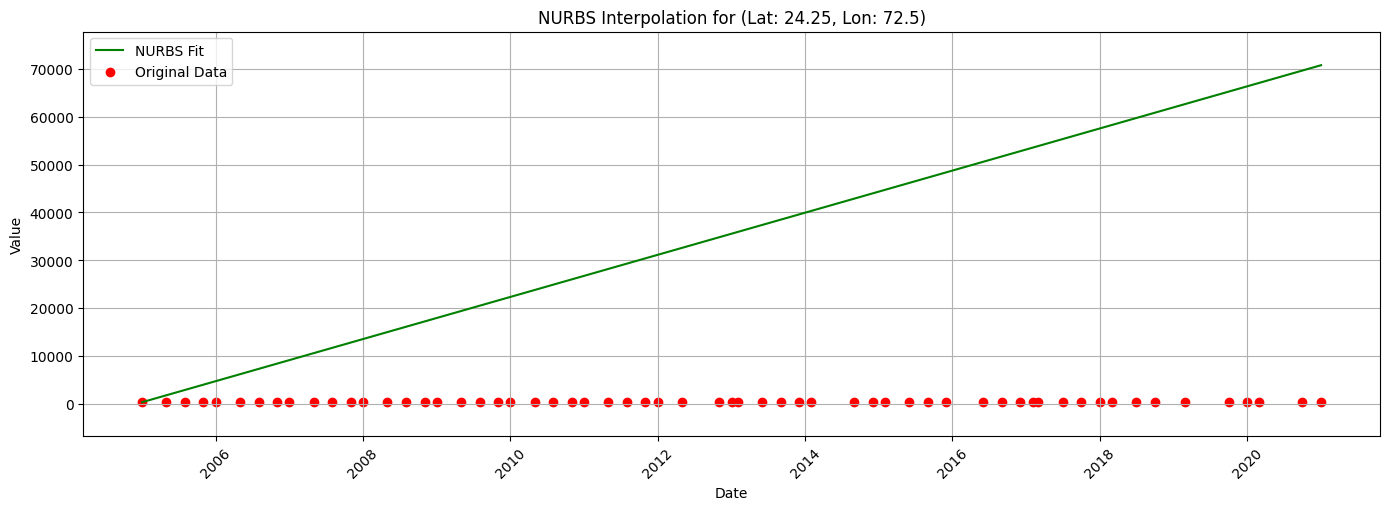

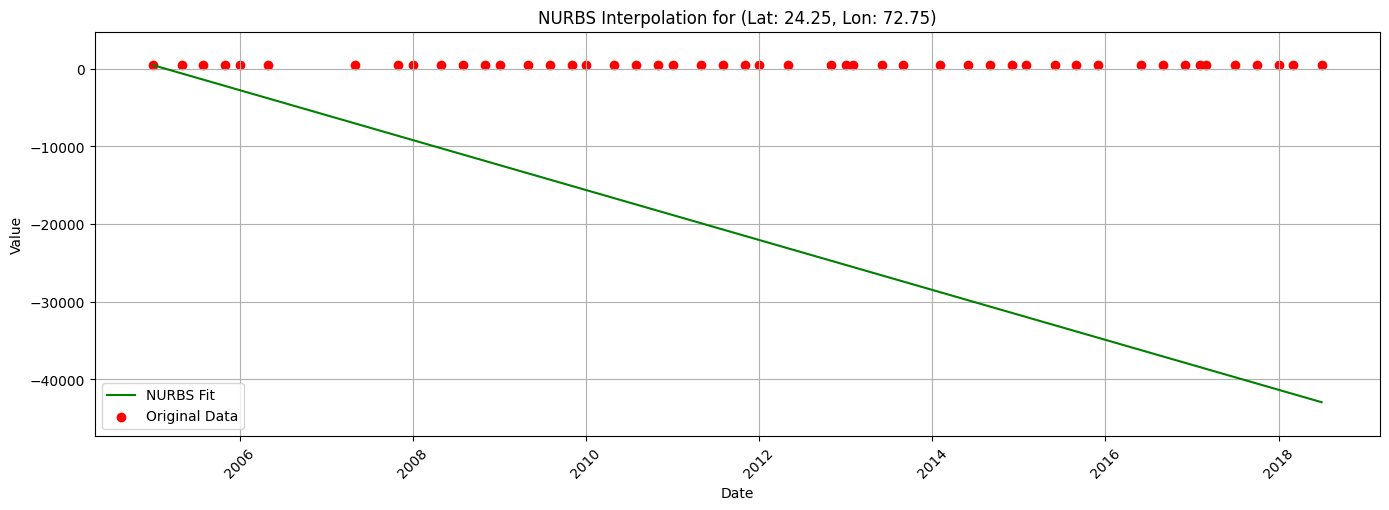

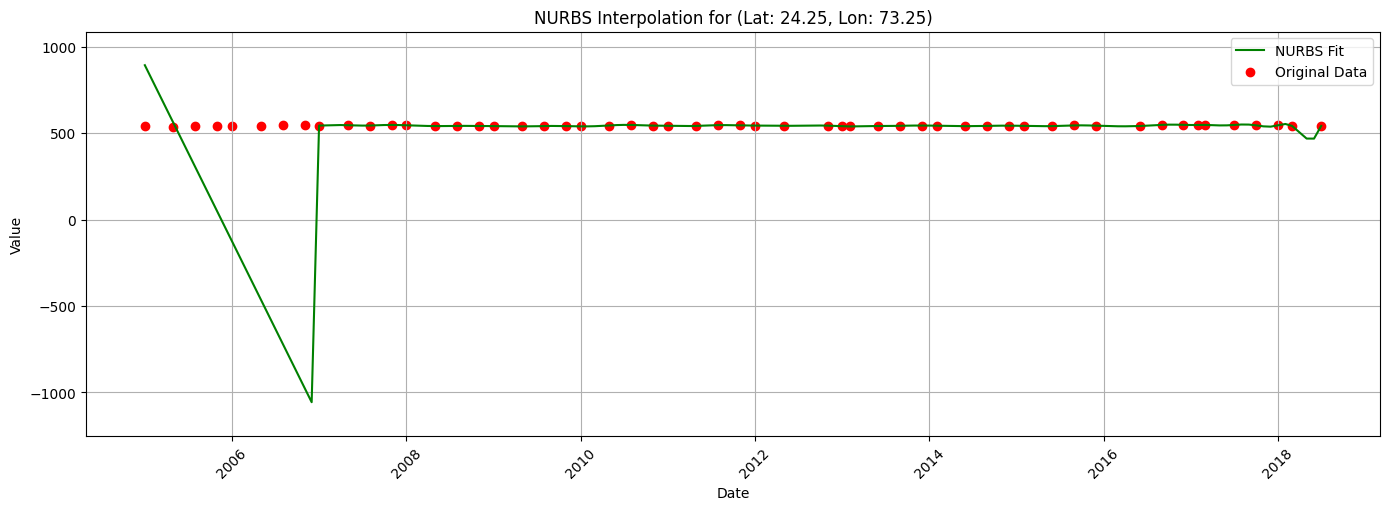

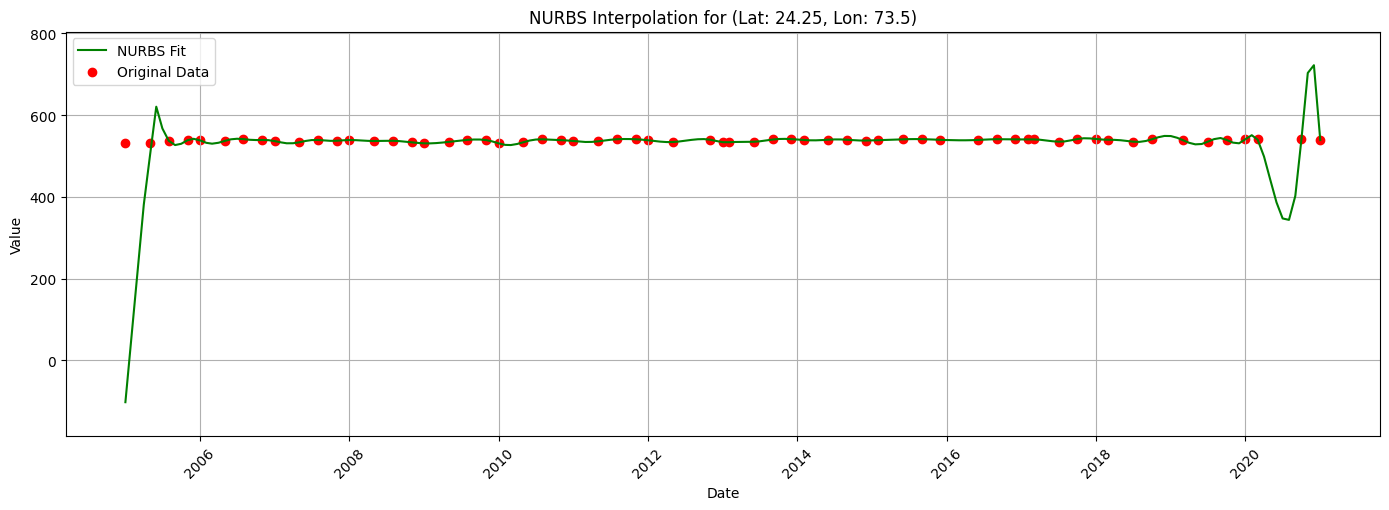

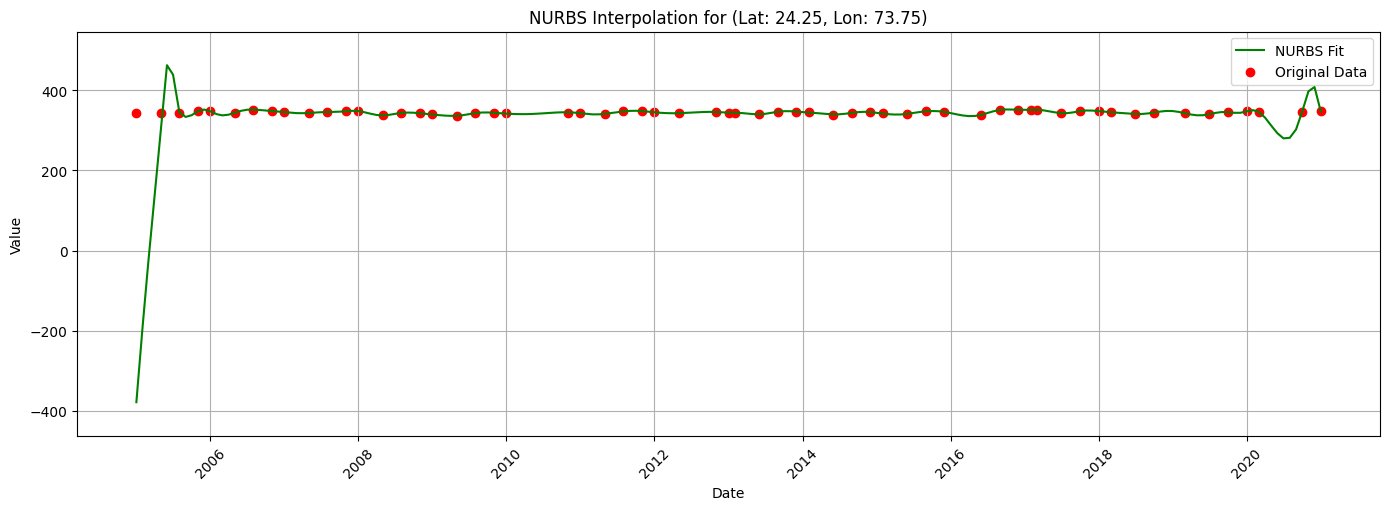

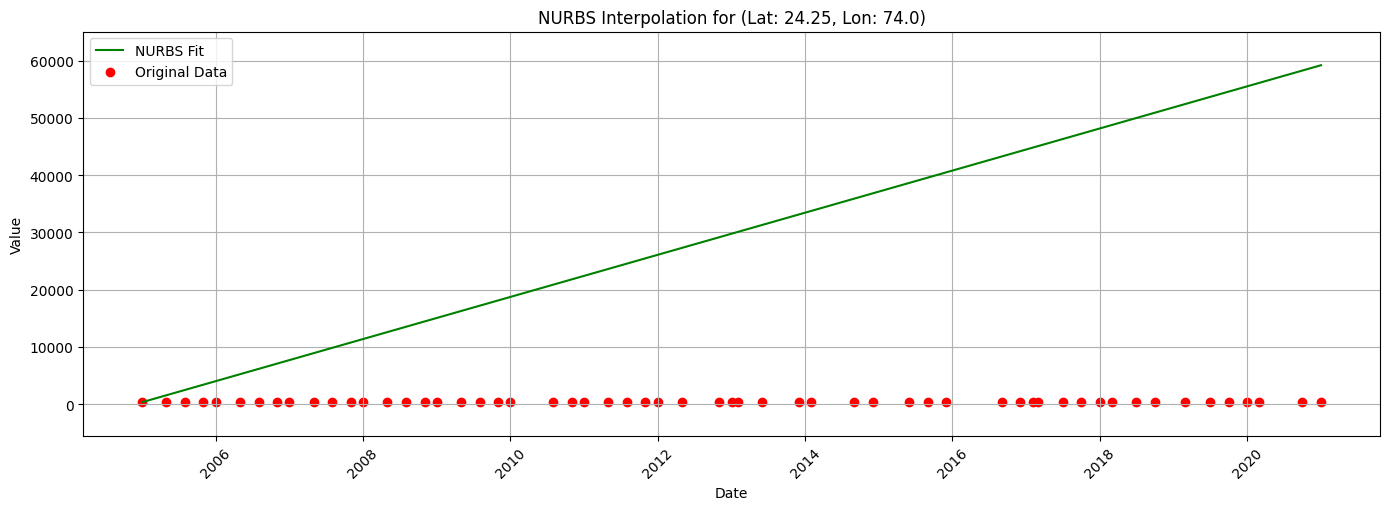

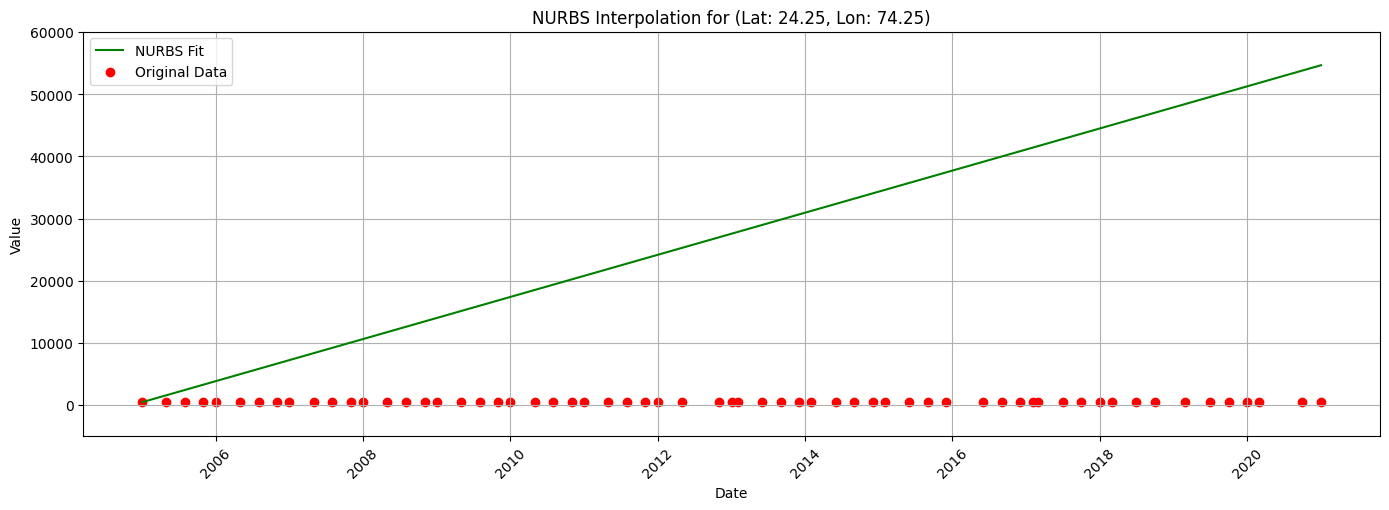

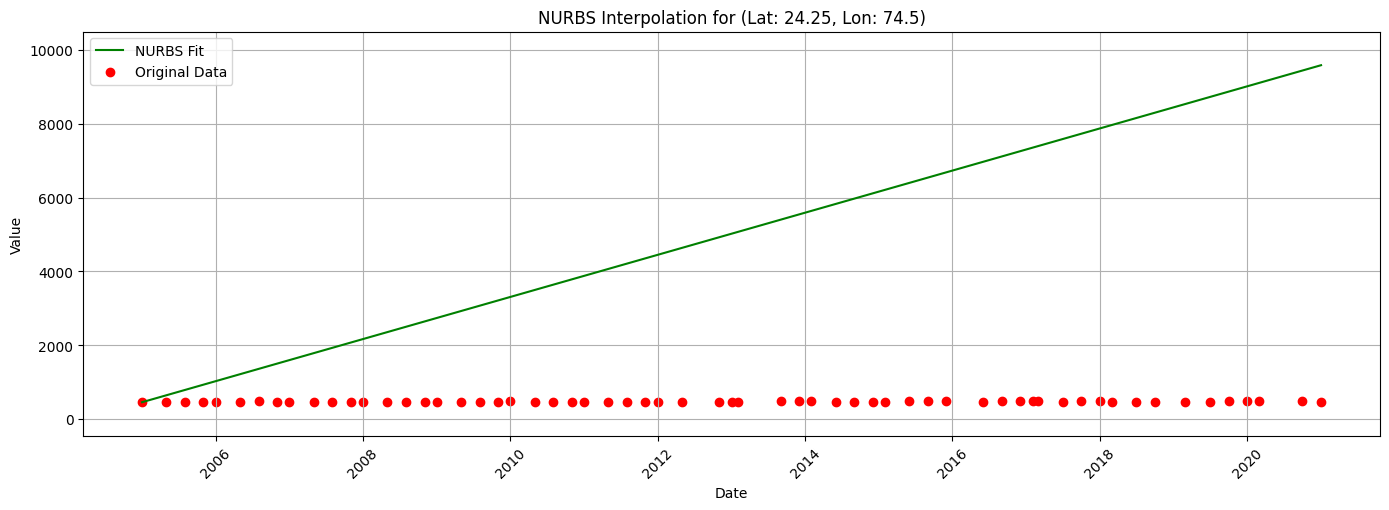

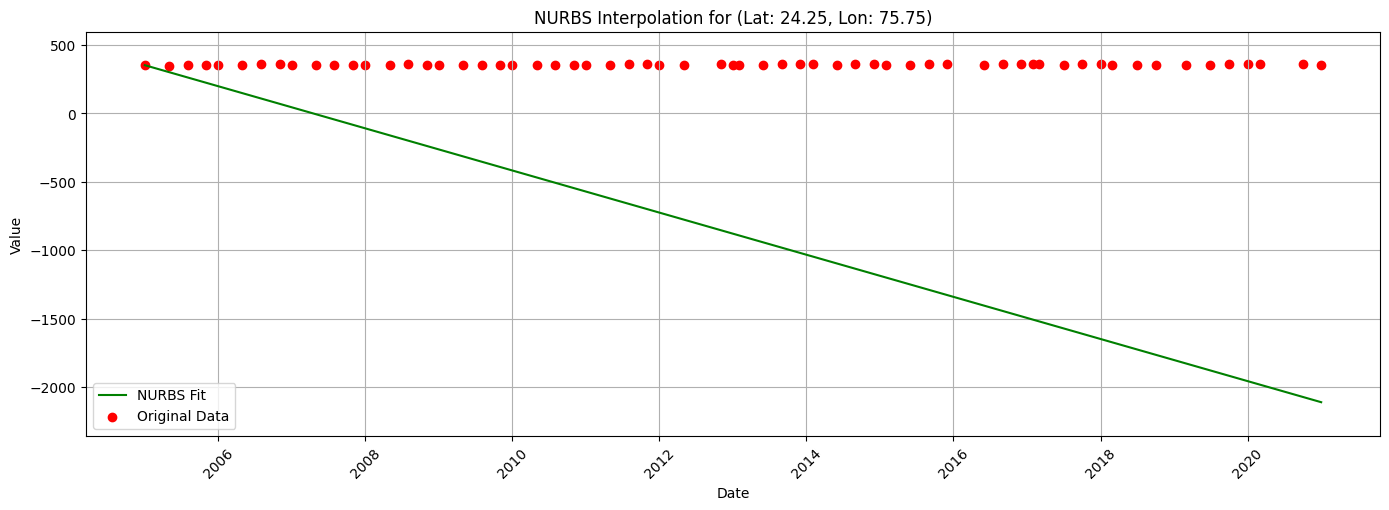

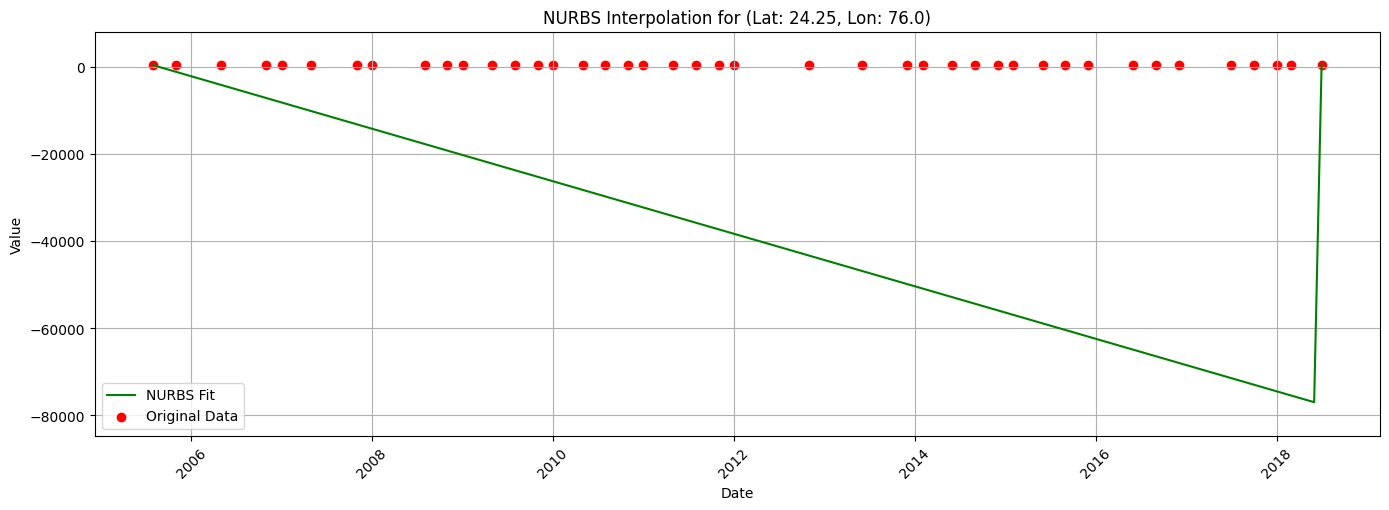

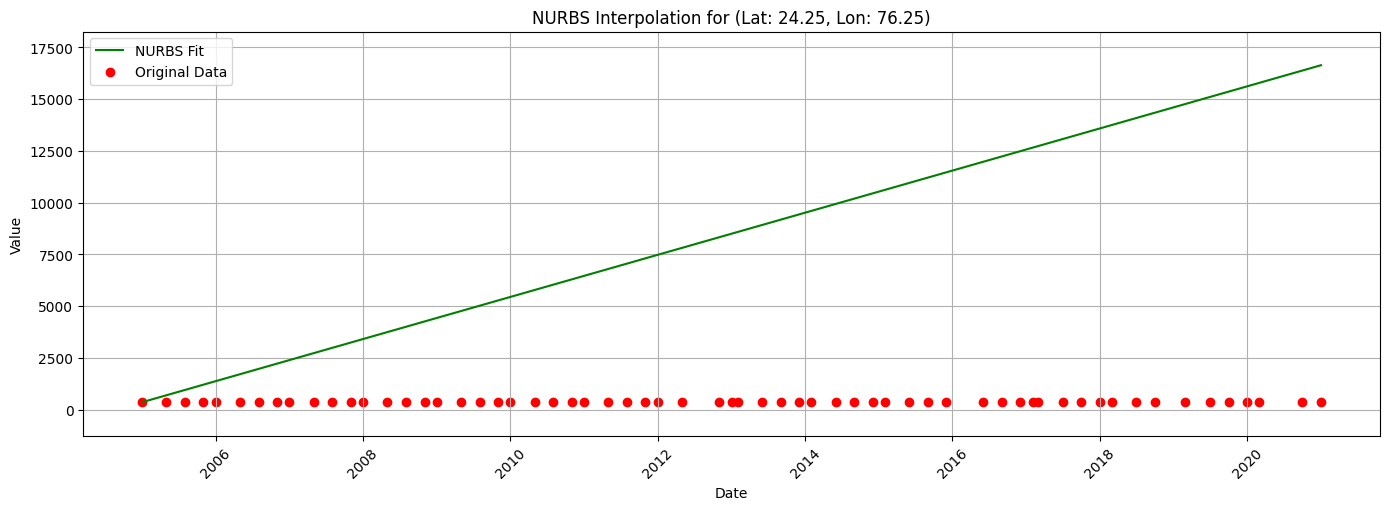

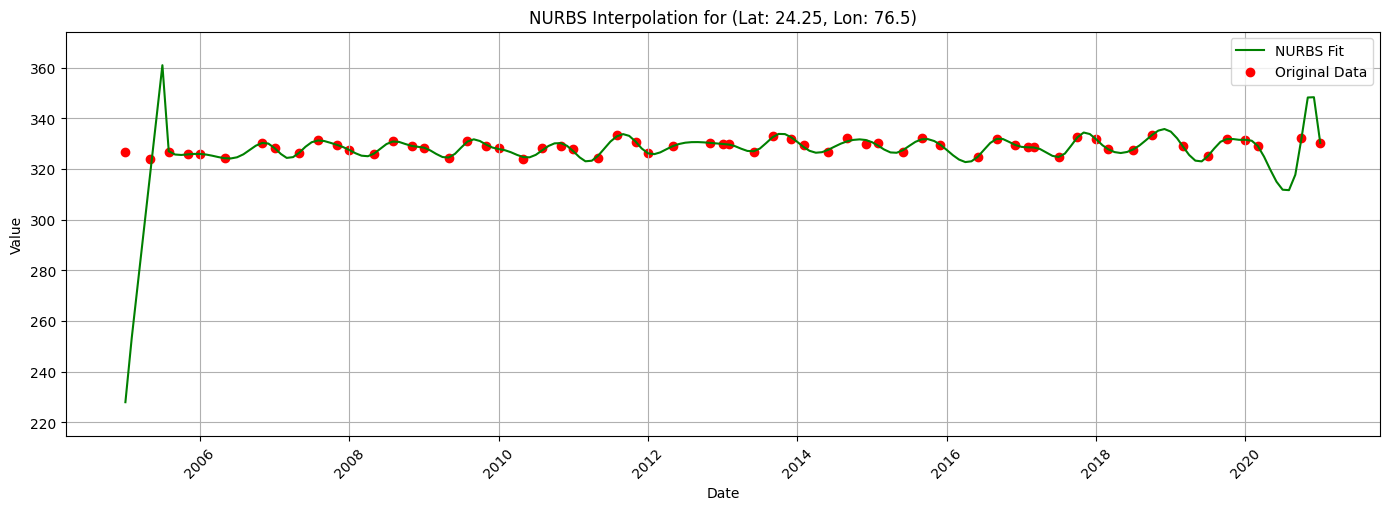

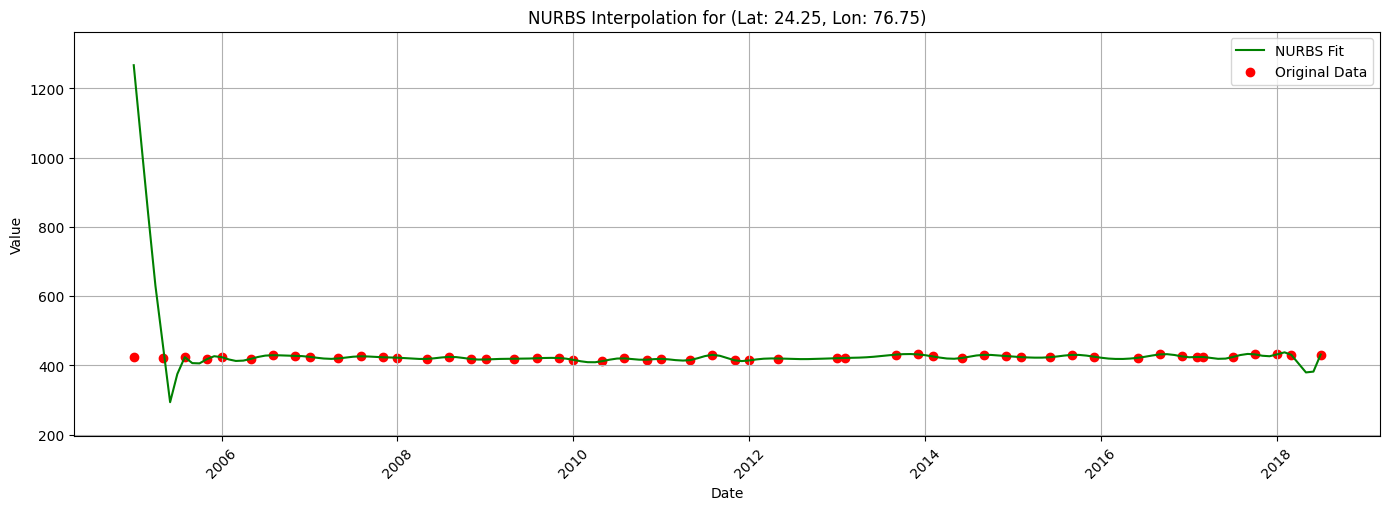

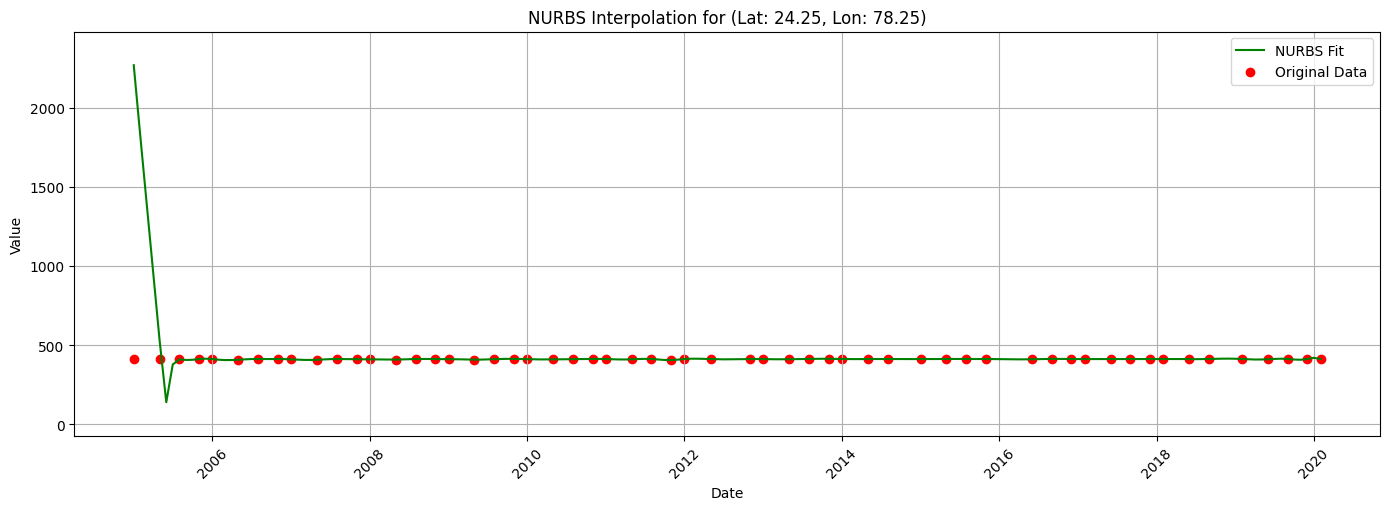

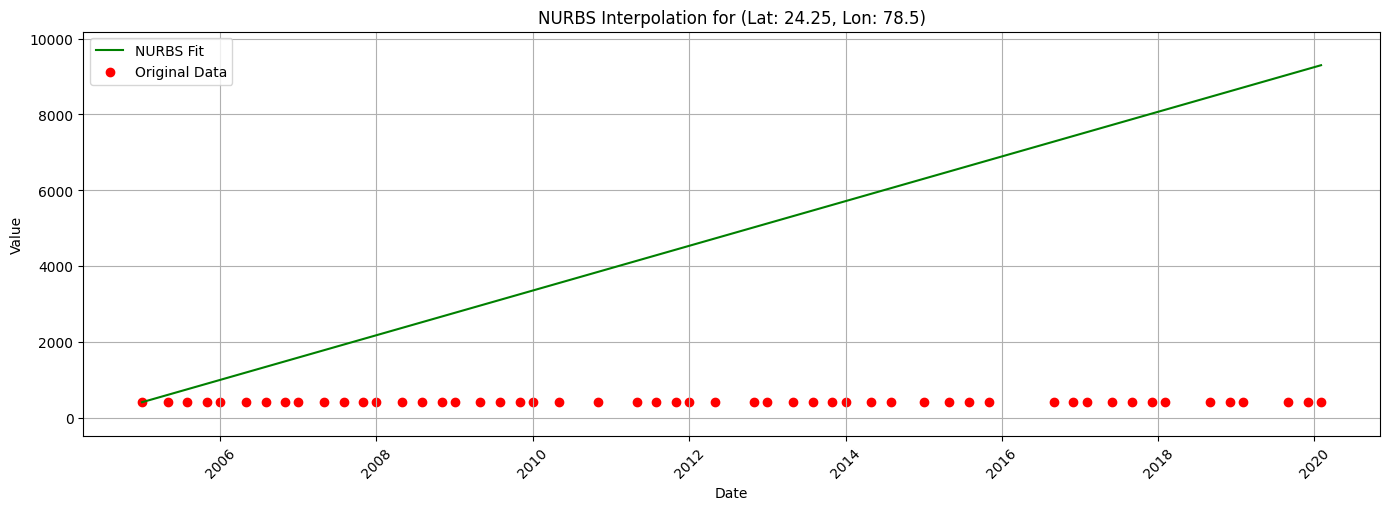

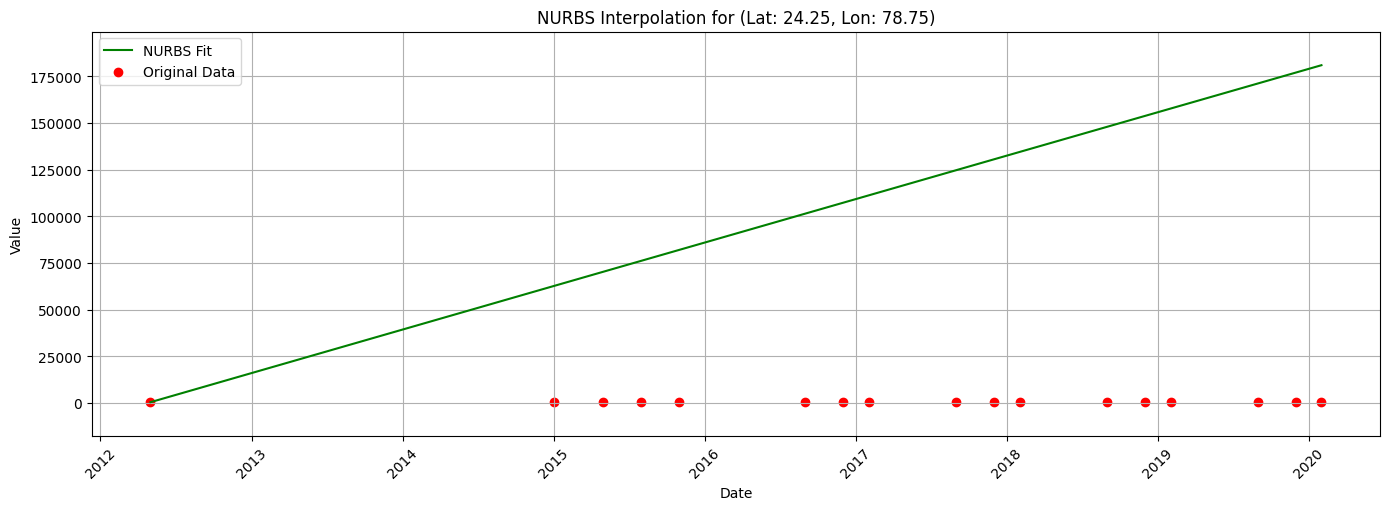

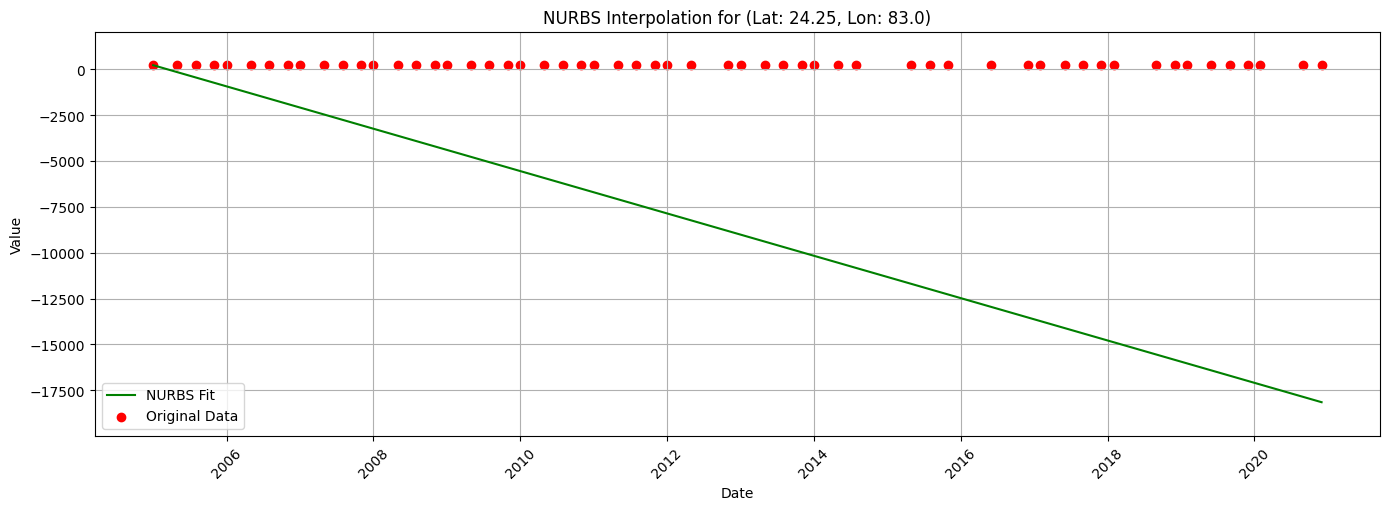

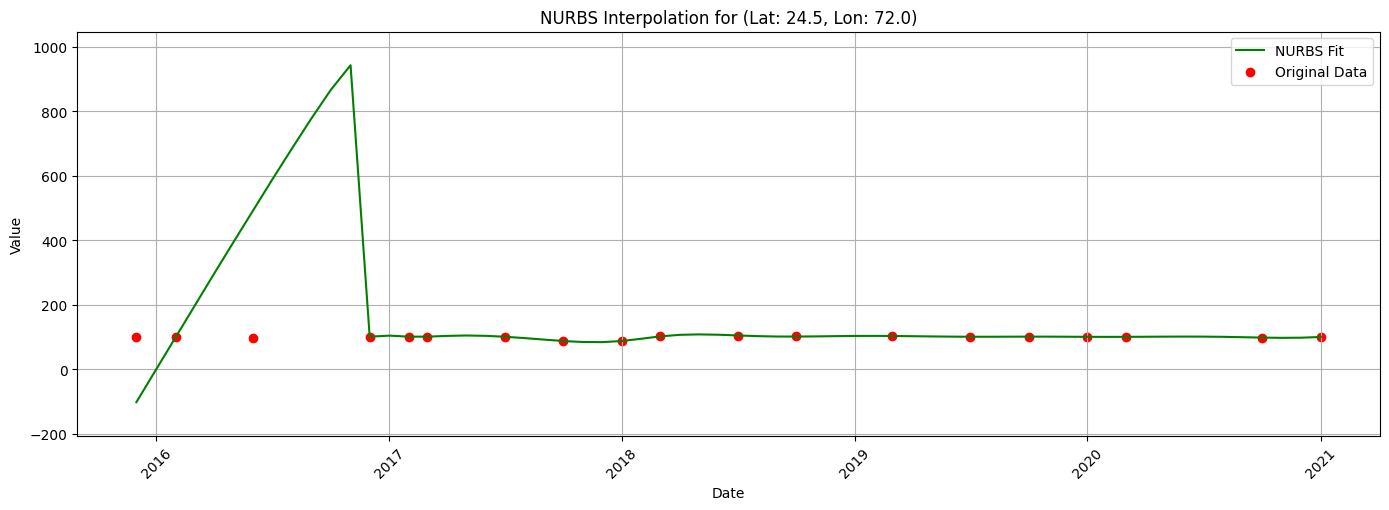

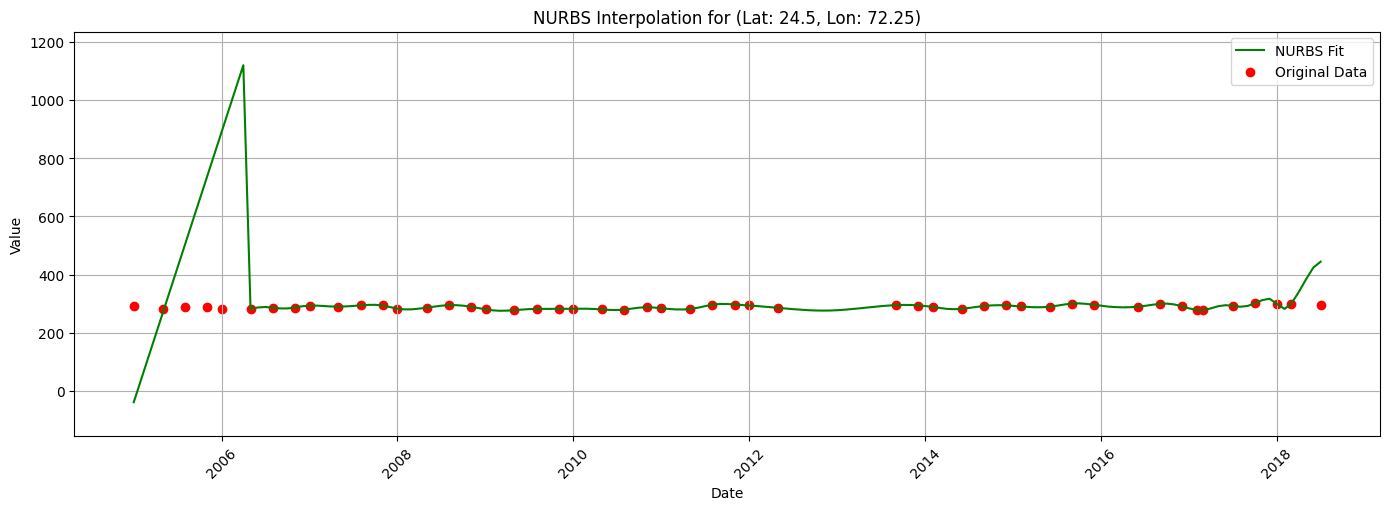

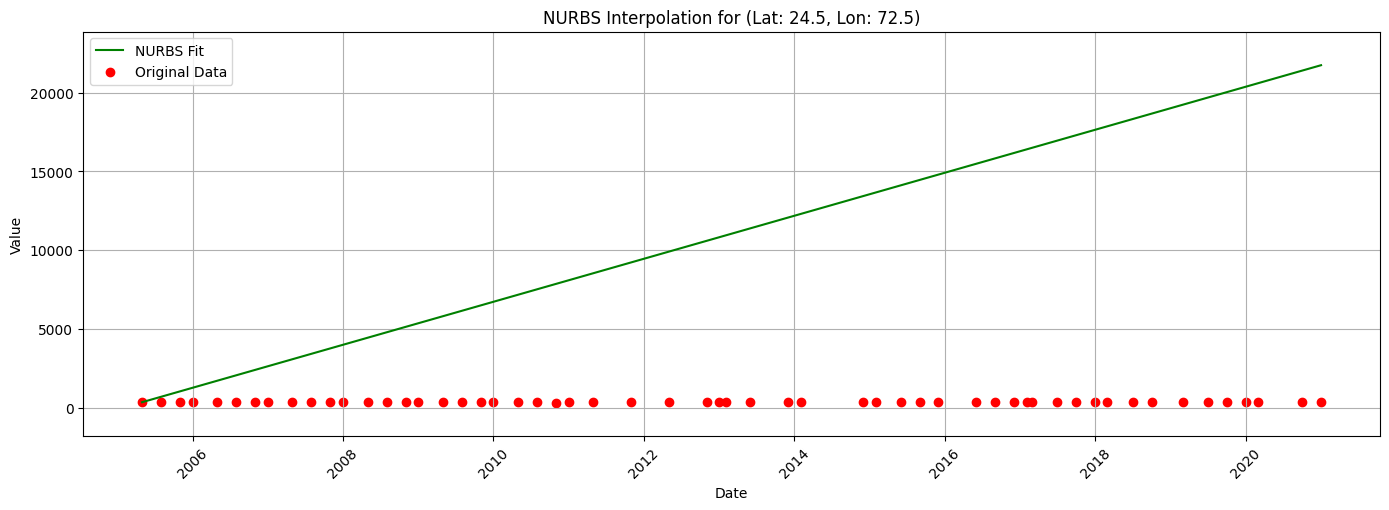

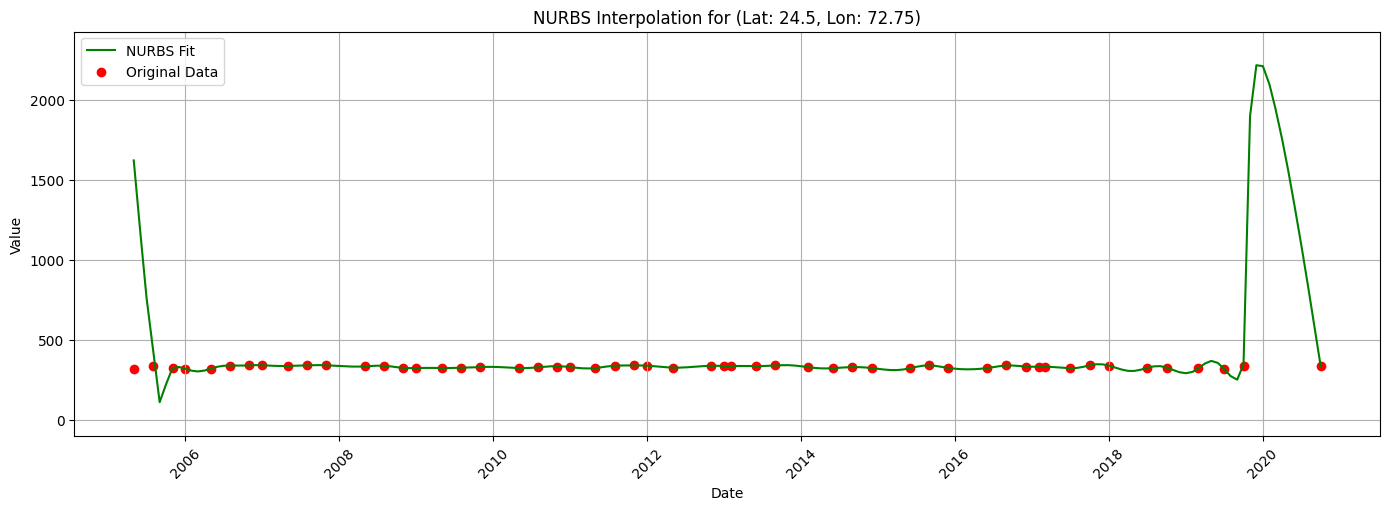

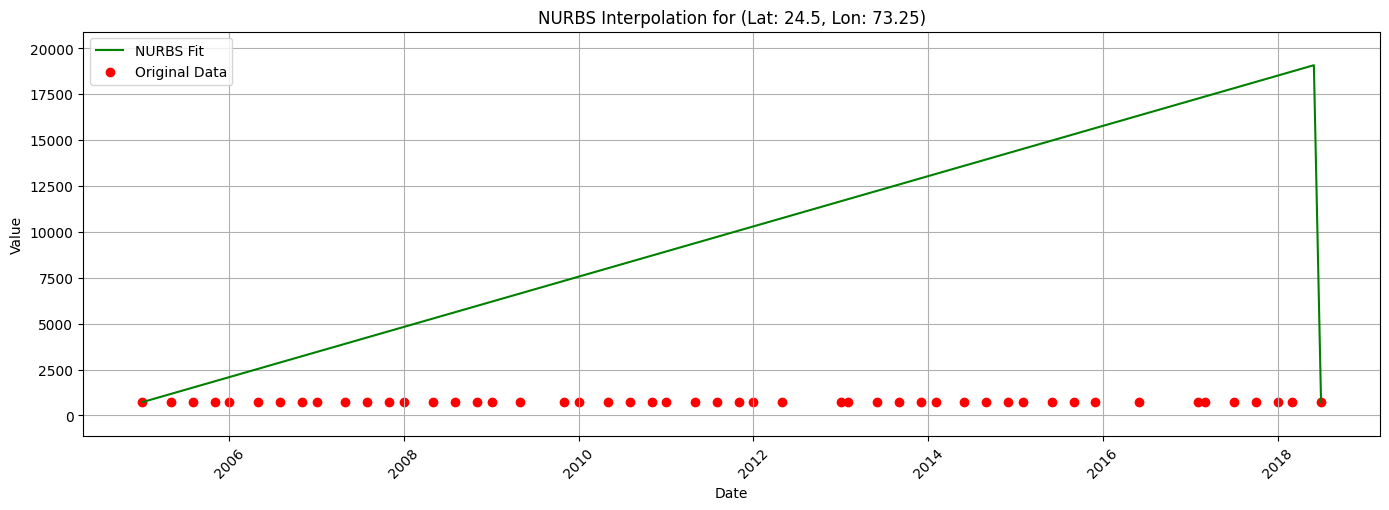

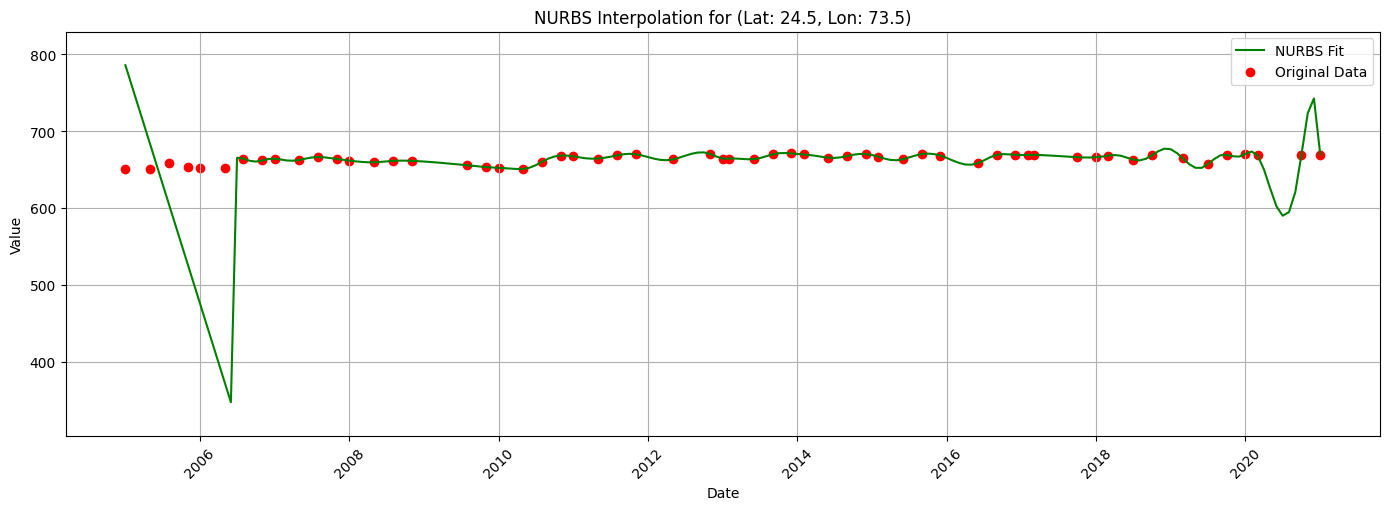

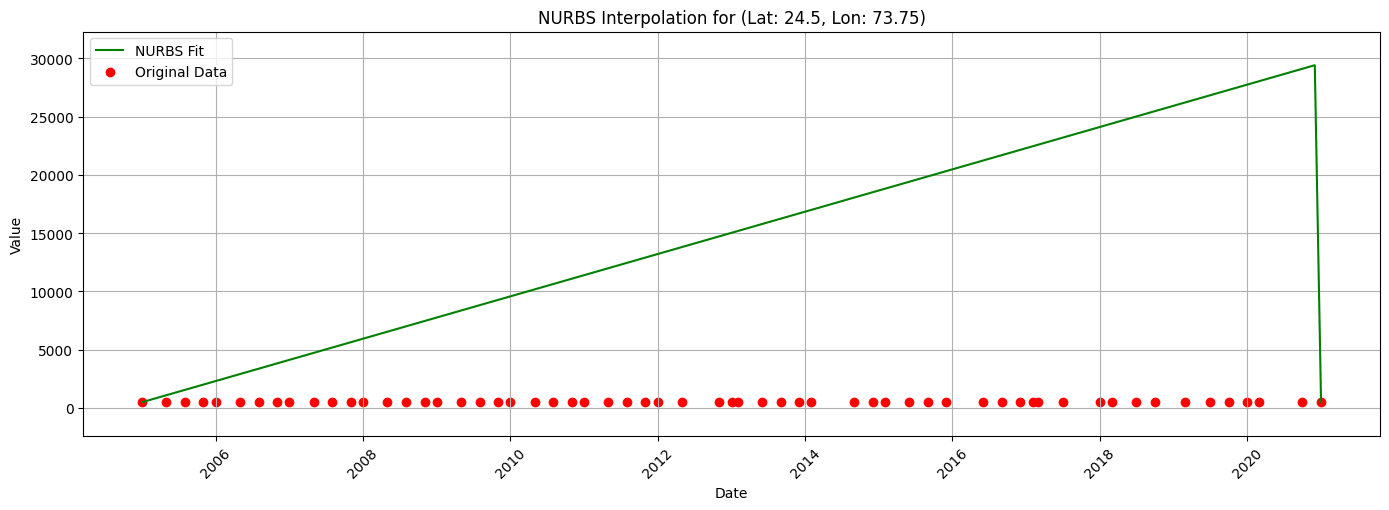

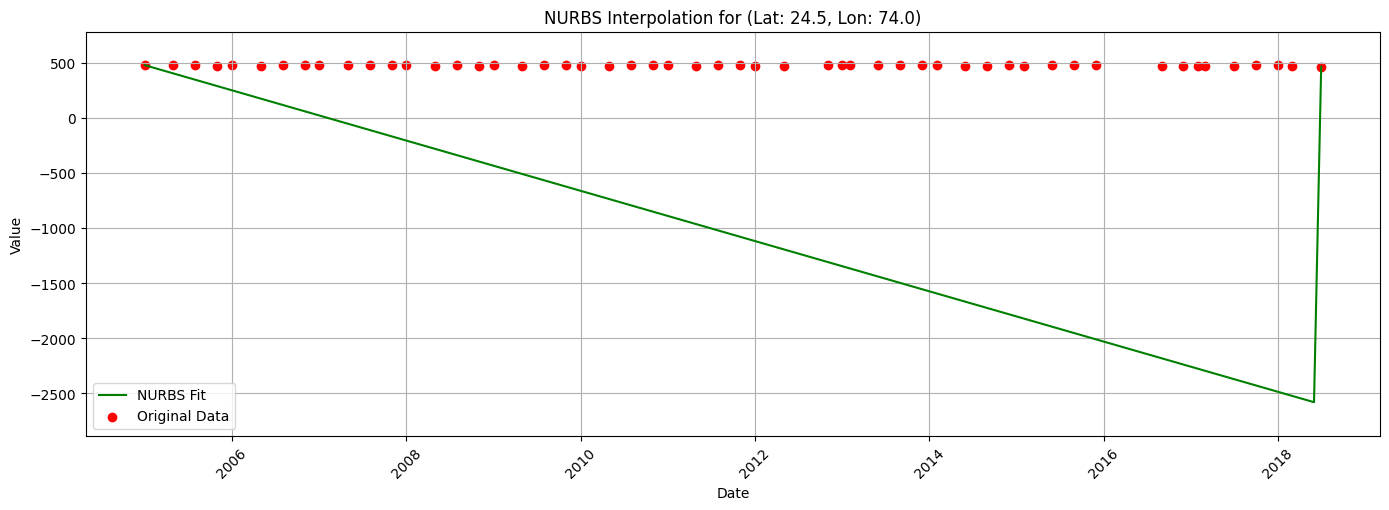

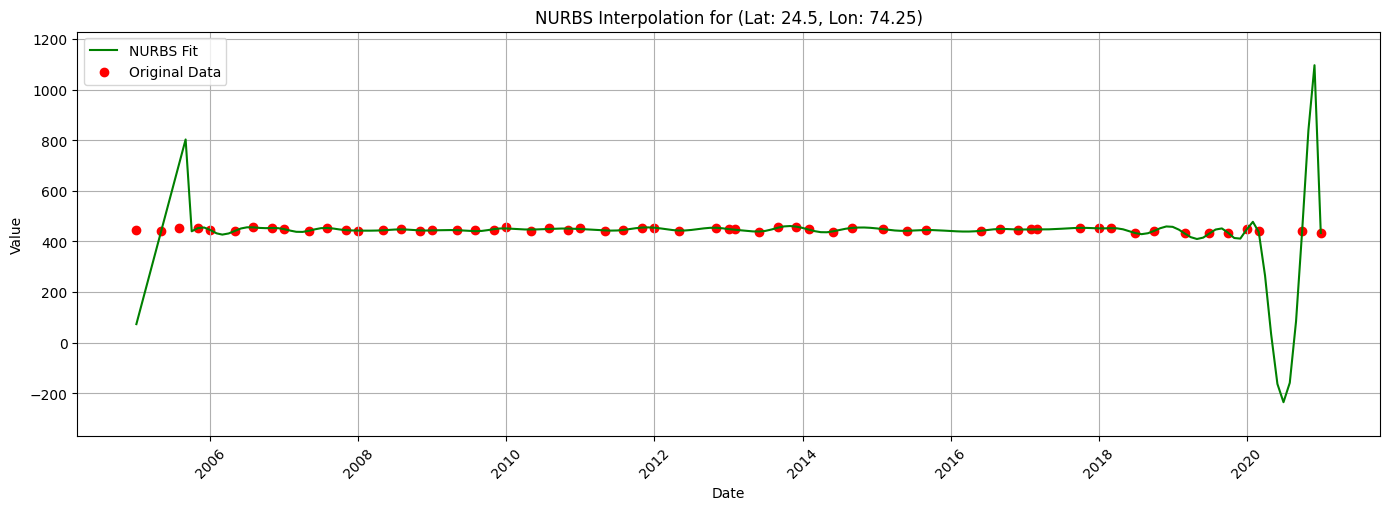

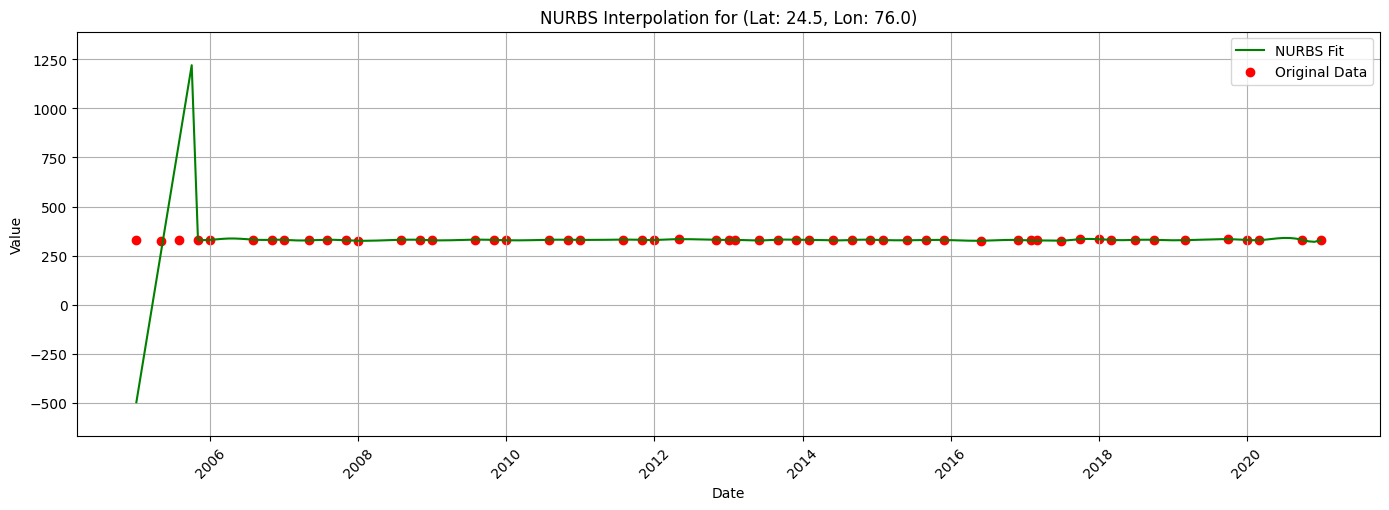

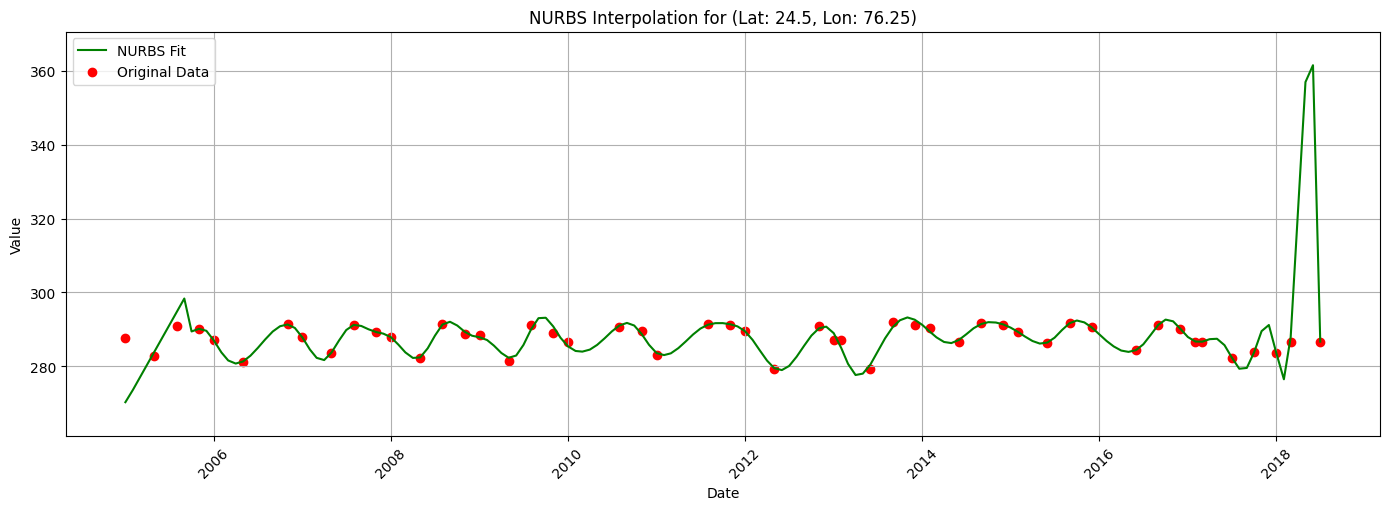

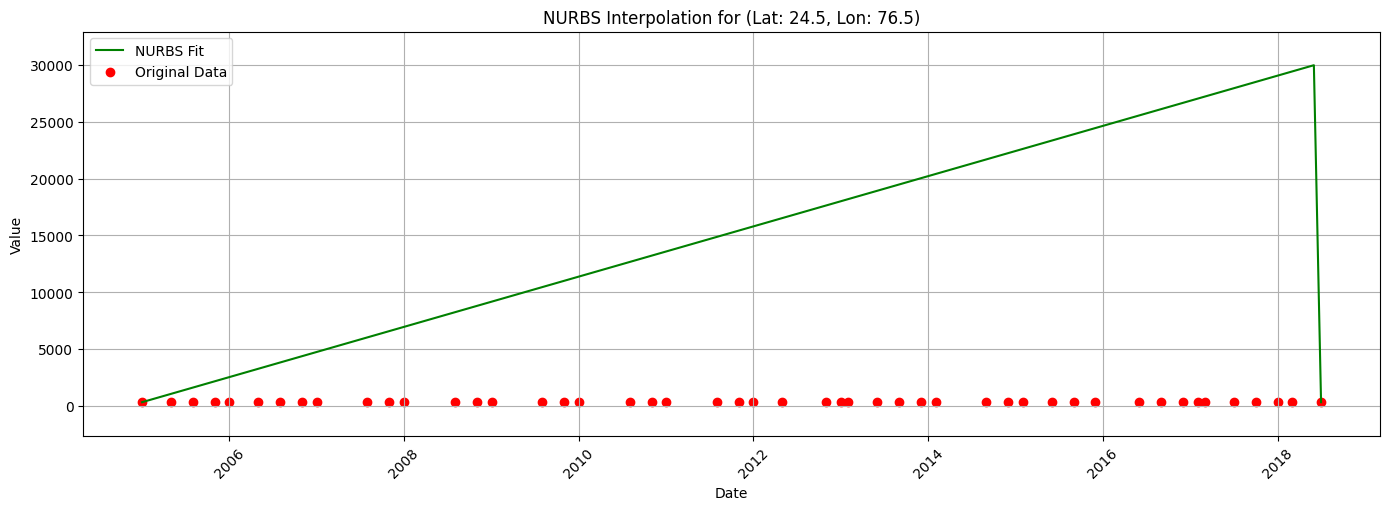

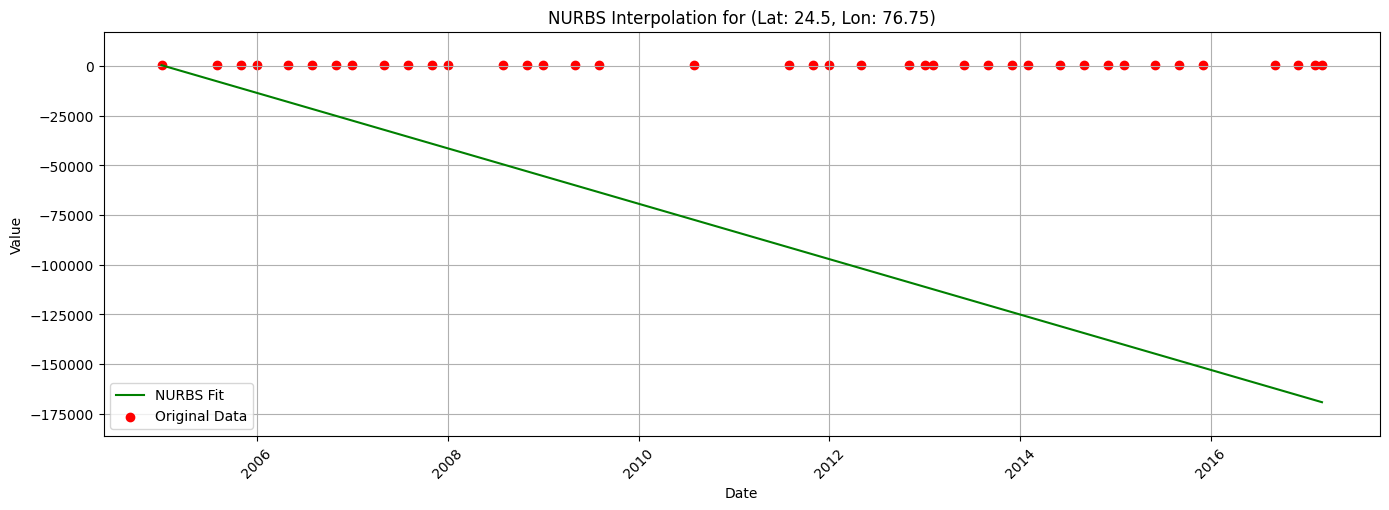

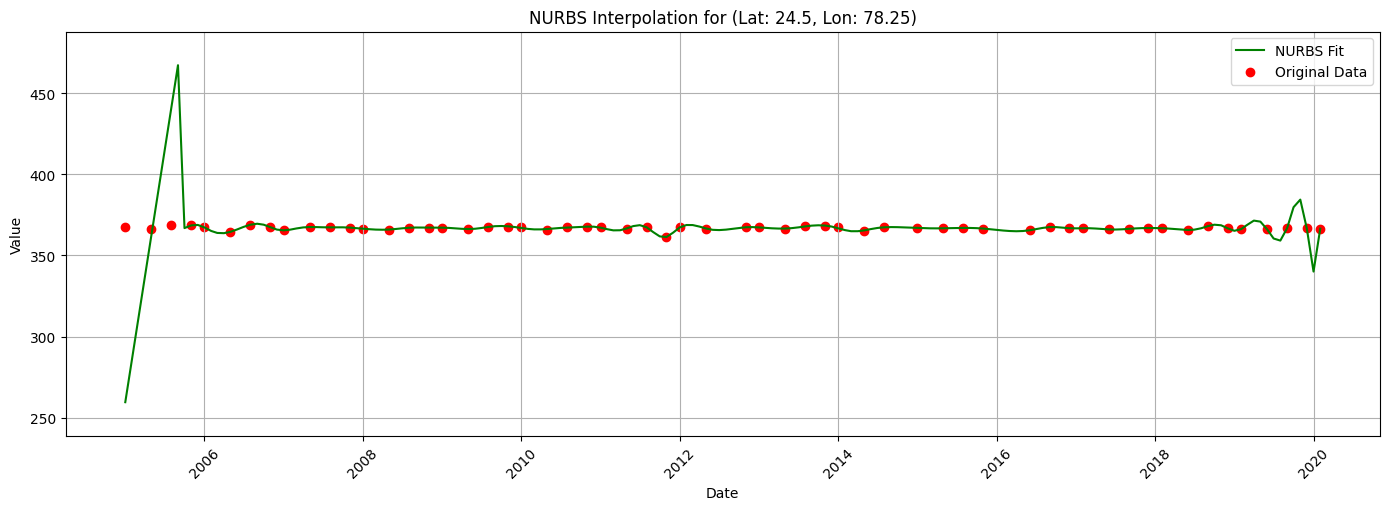

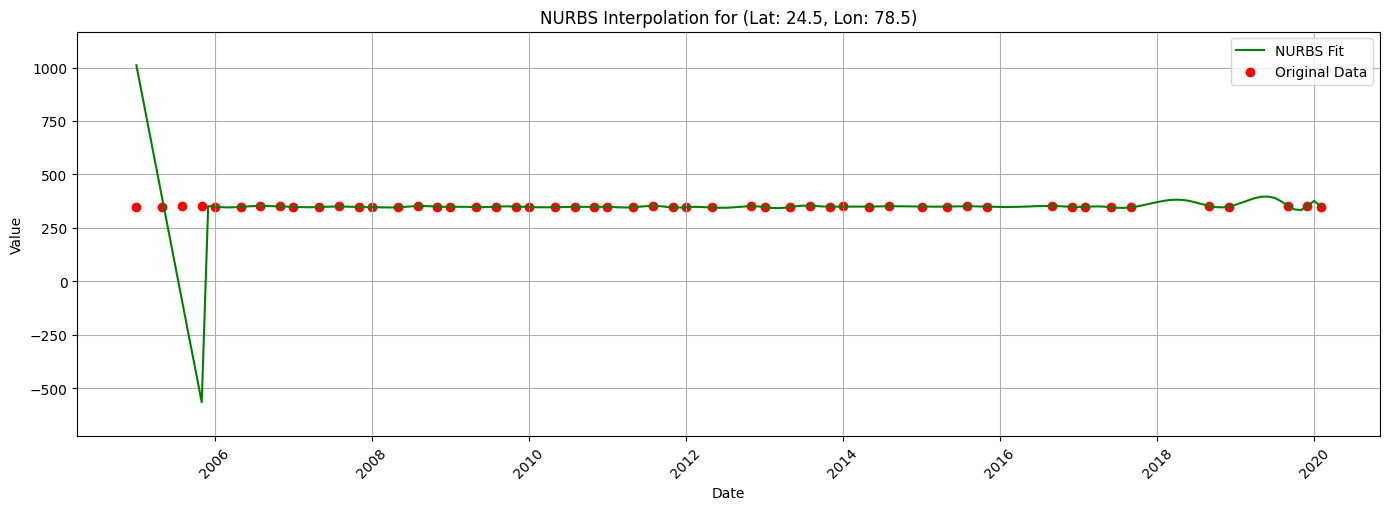

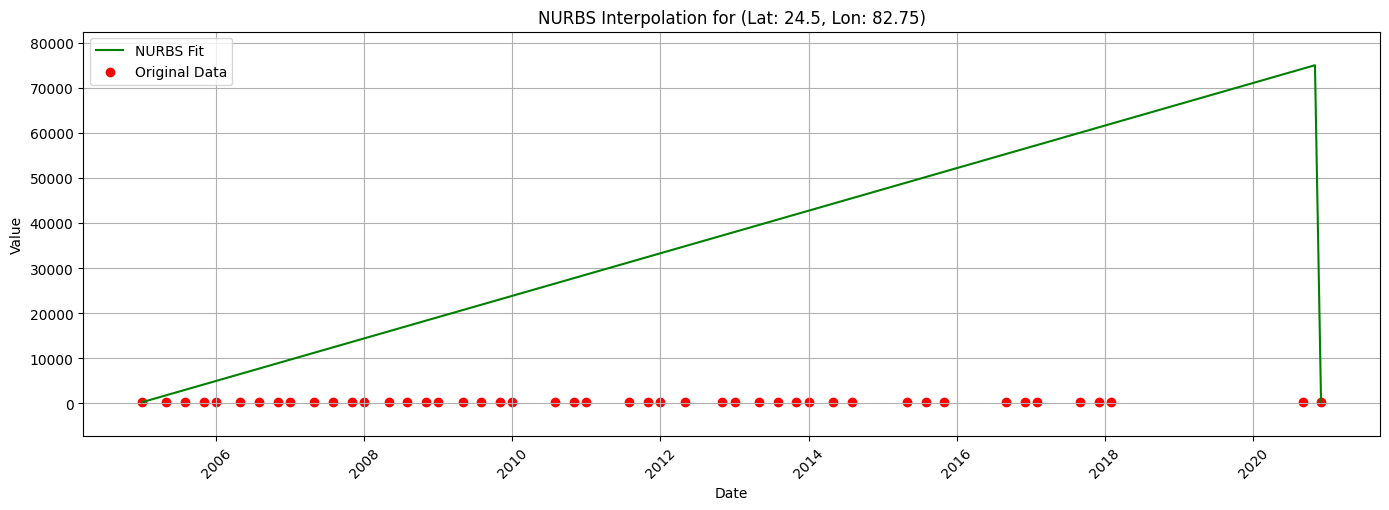

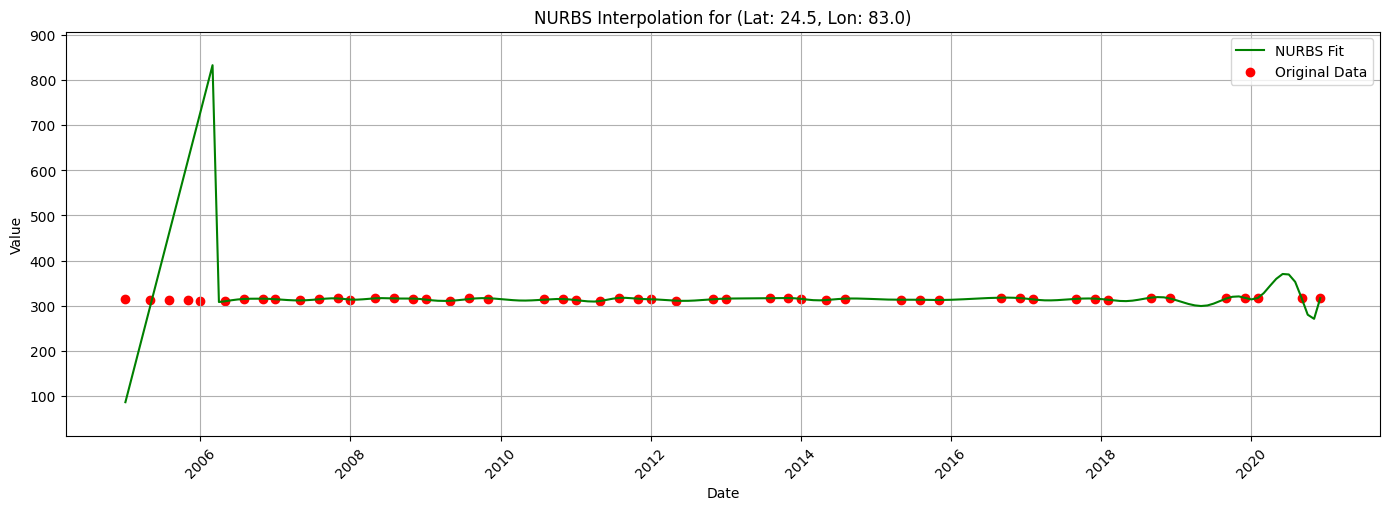

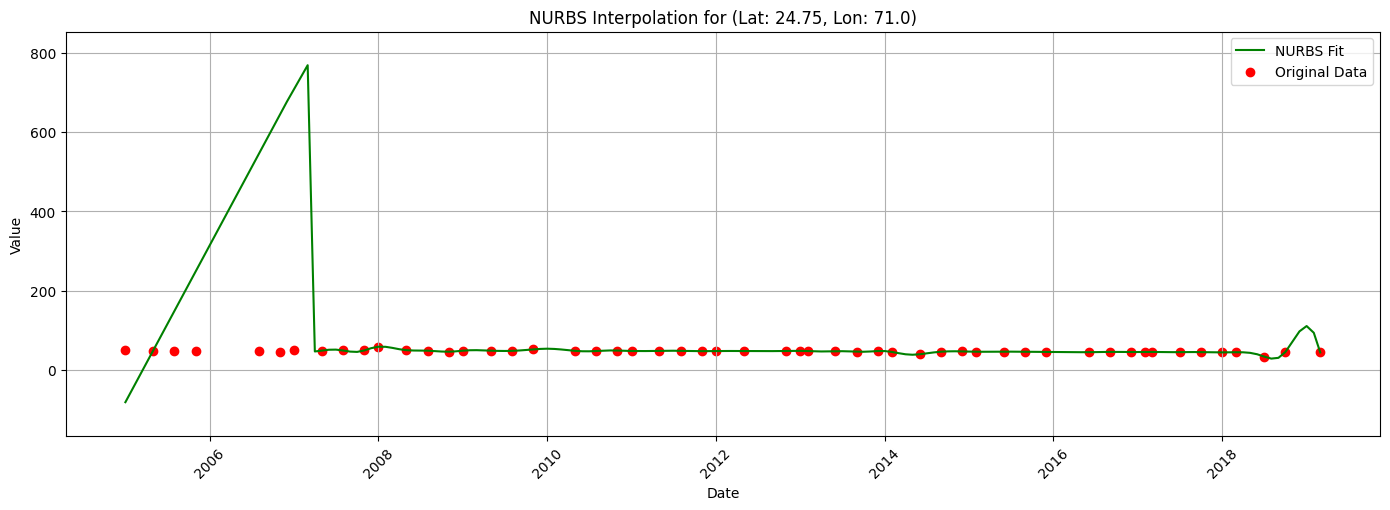

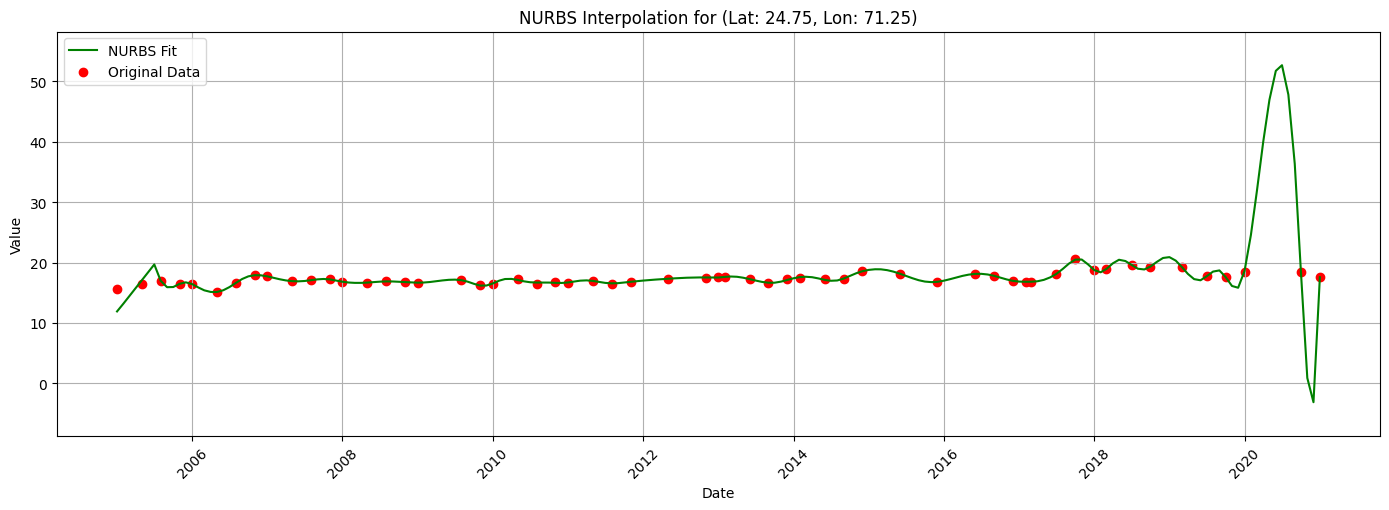

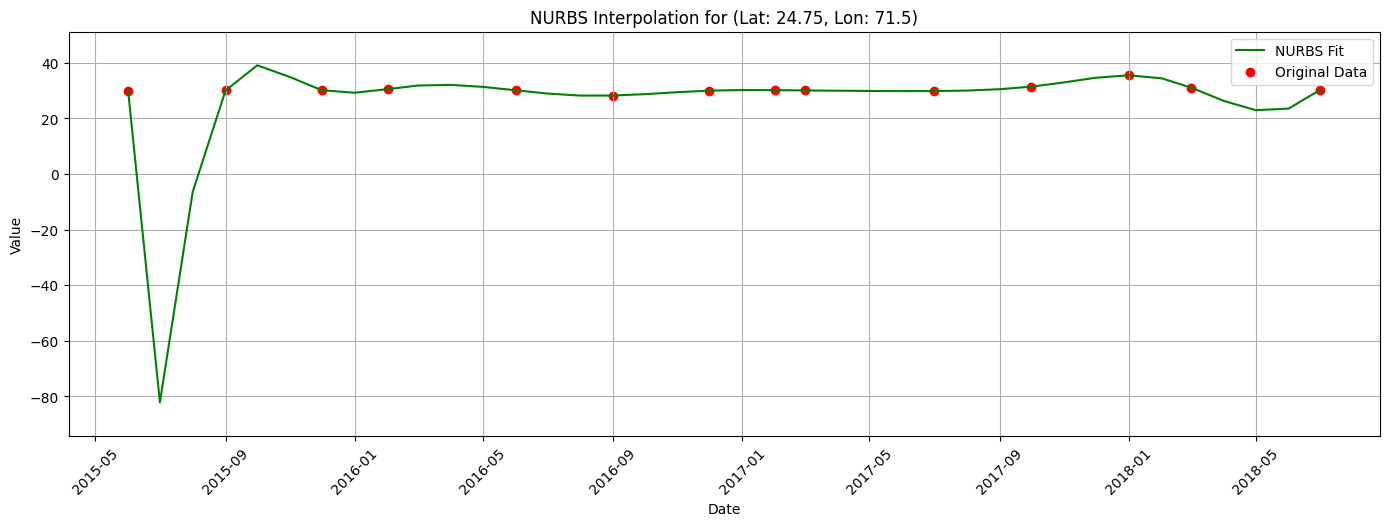

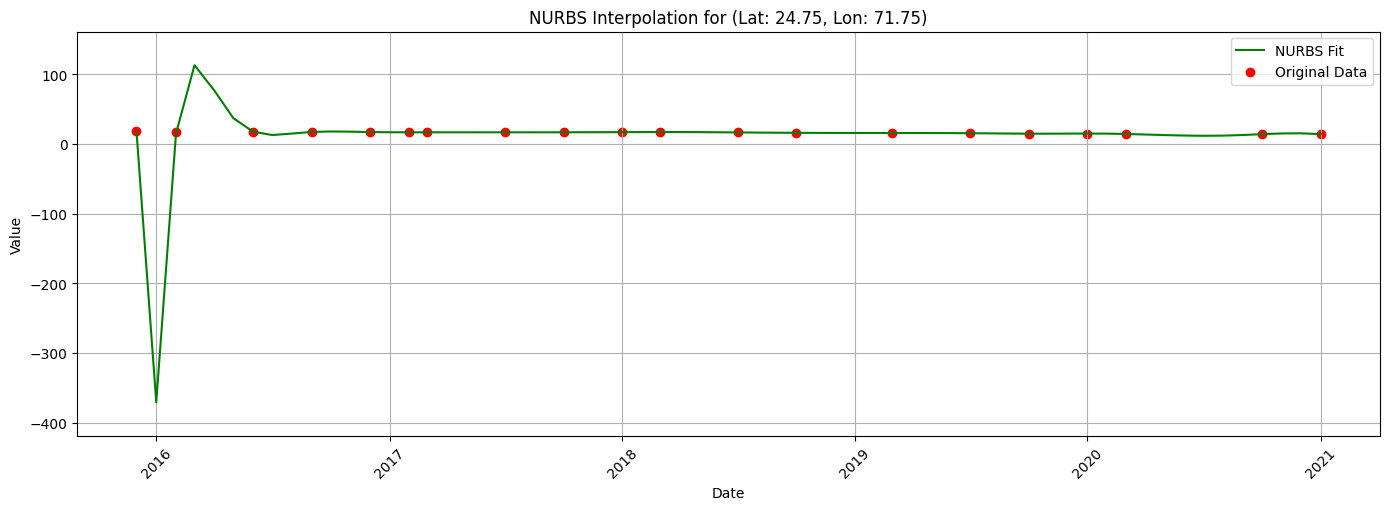

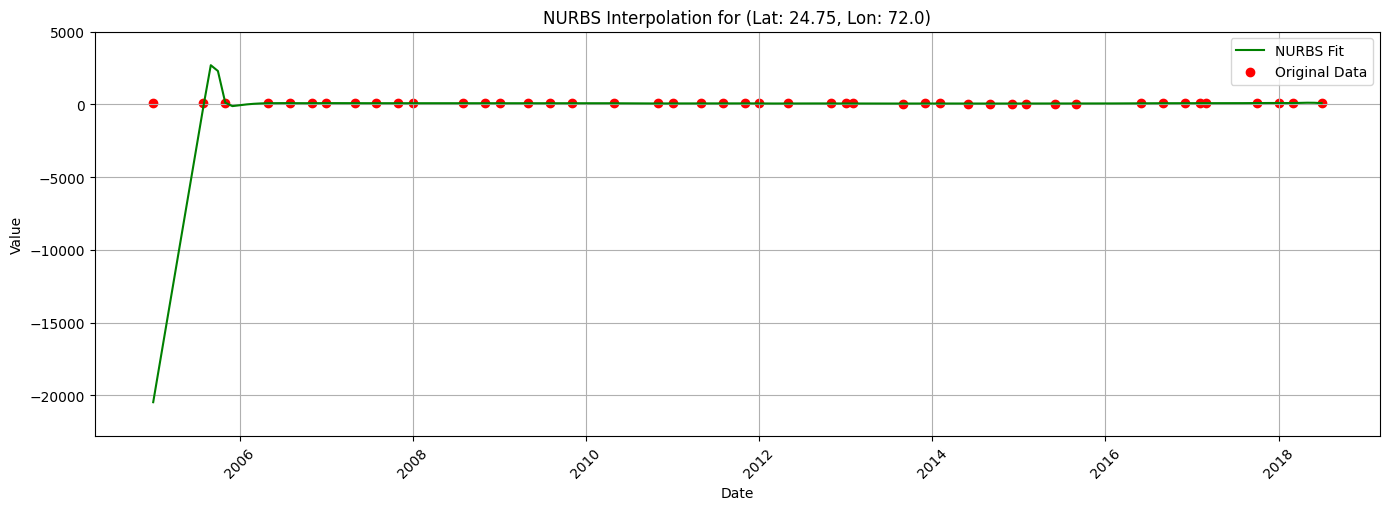

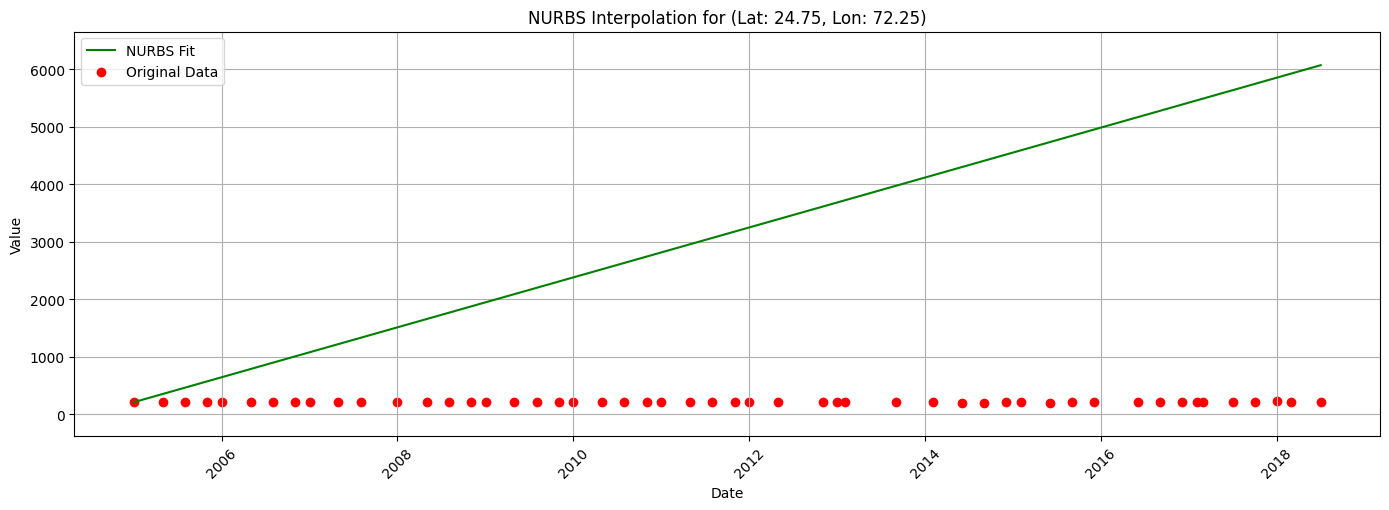

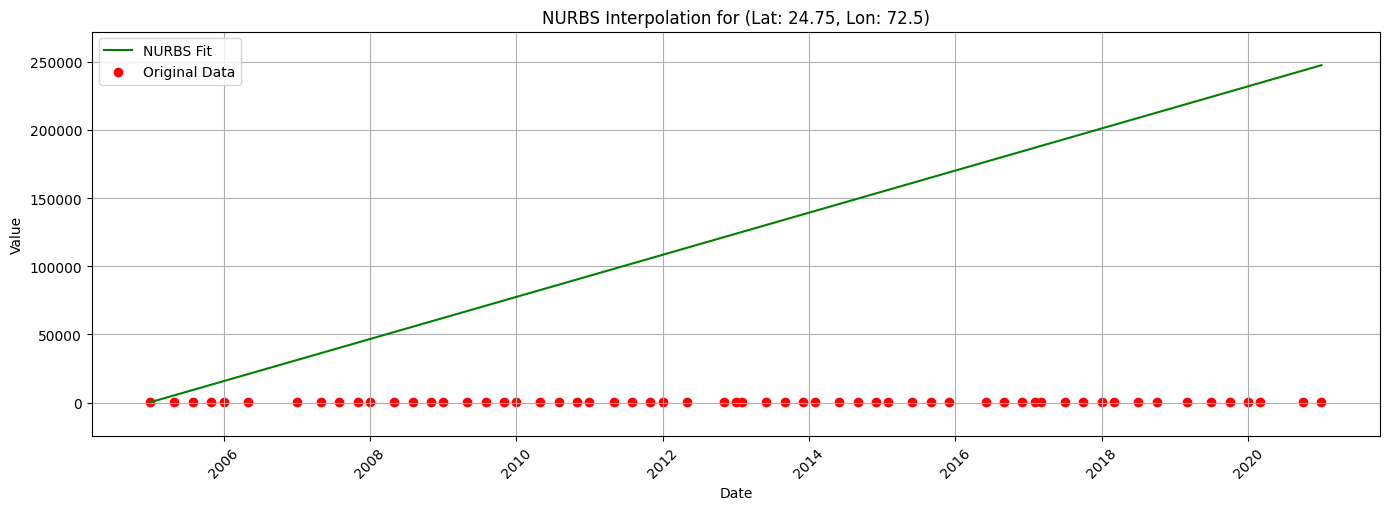

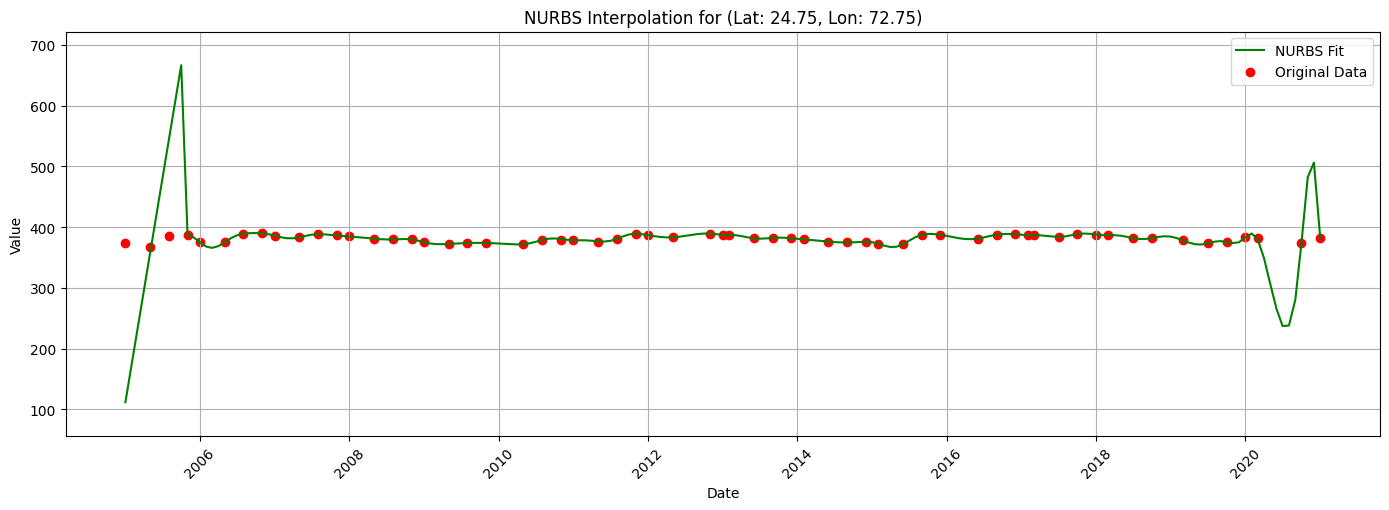

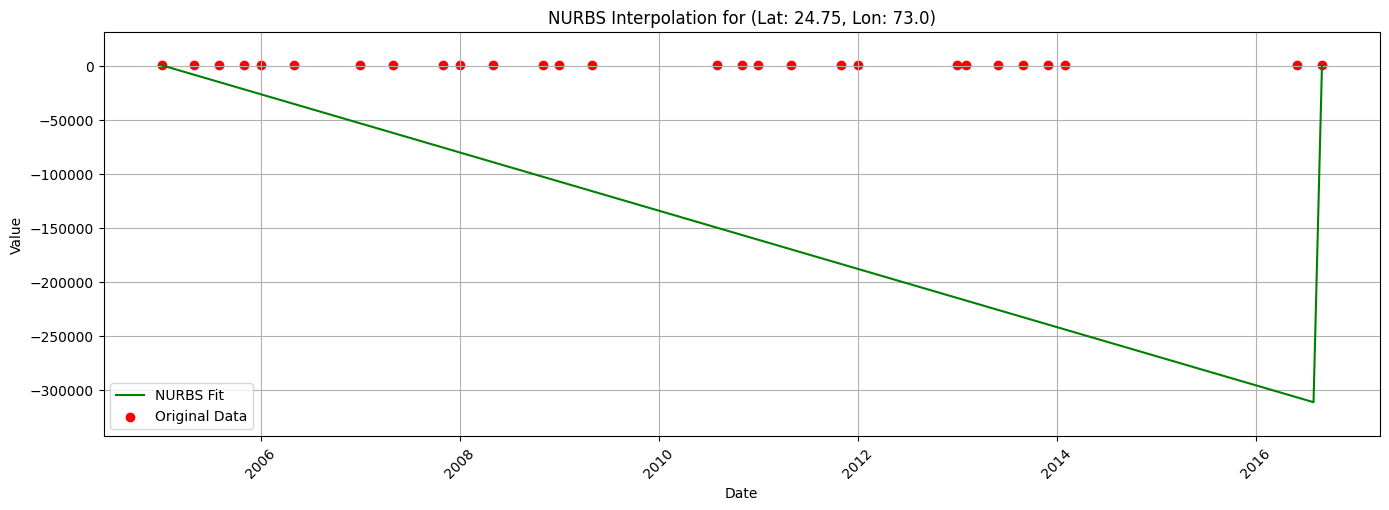

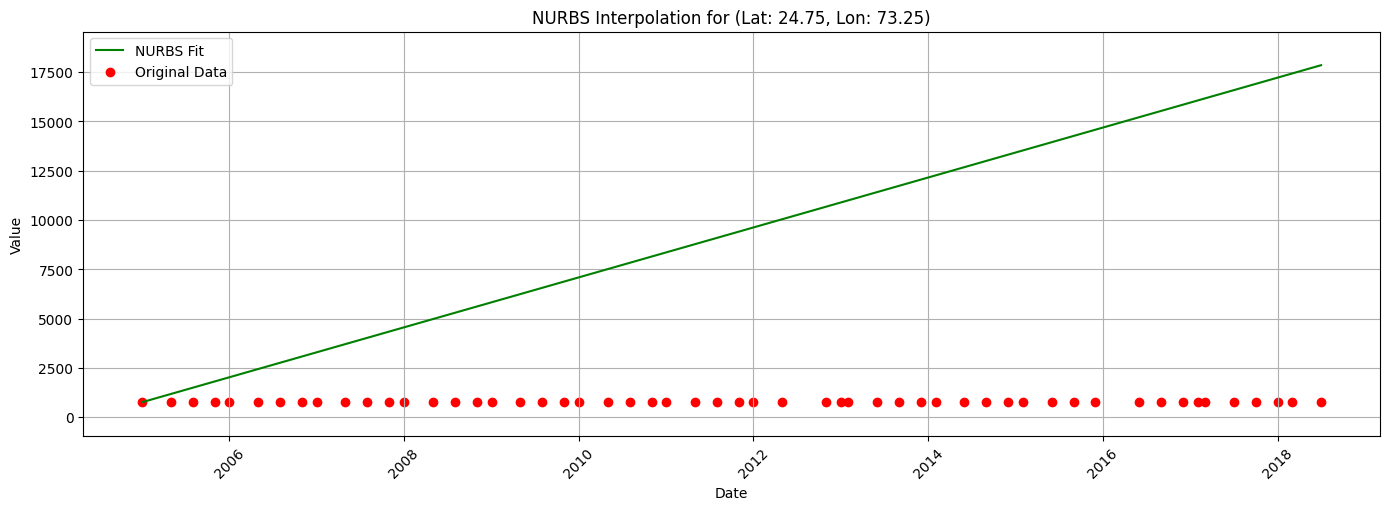

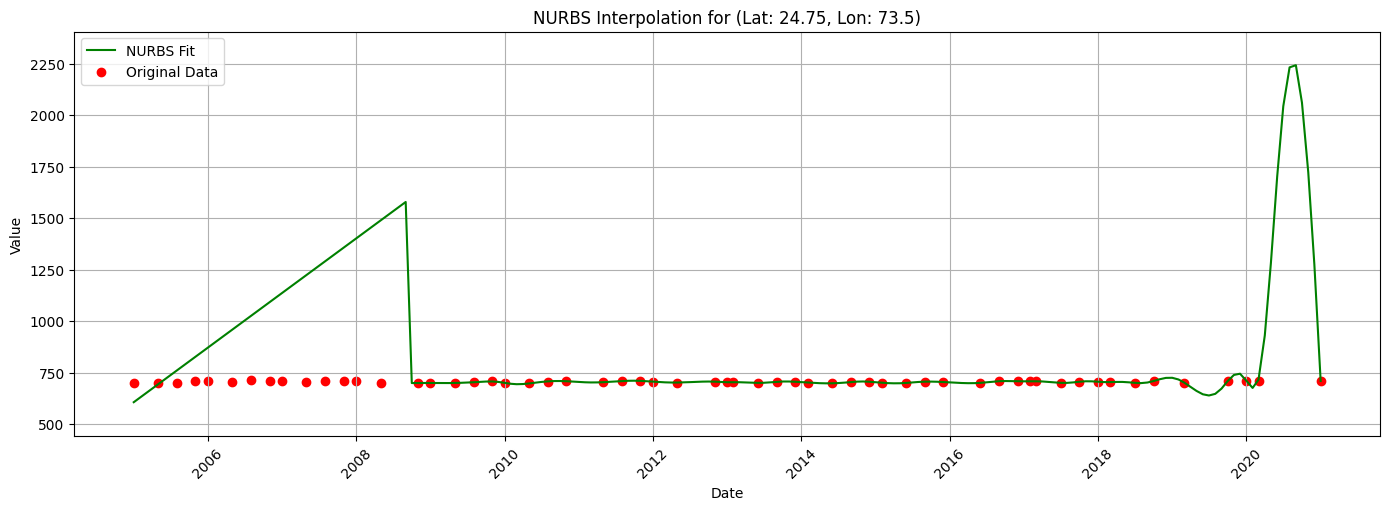

KeyboardInterrupt: 

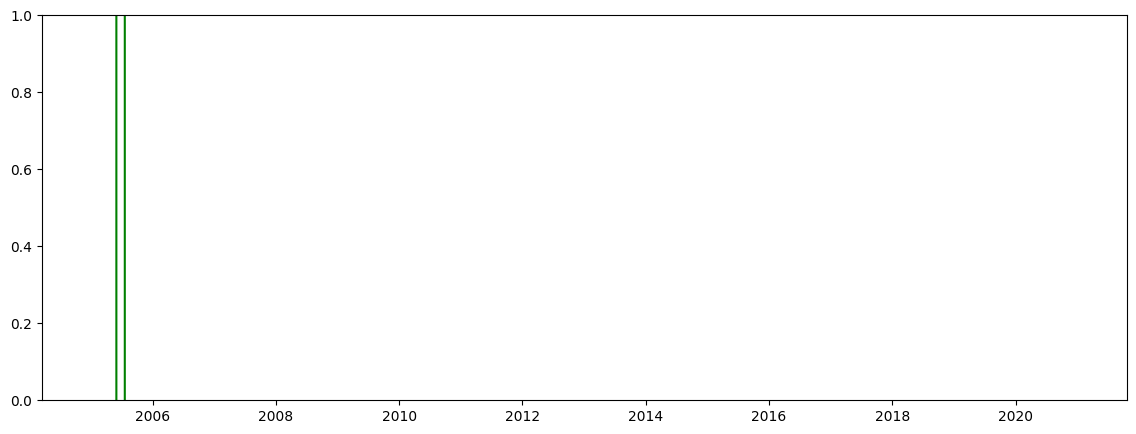

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from geomdl import BSpline
from geomdl.fitting import approximate_curve
from geomdl.visualization import VisMPL

# ---------- Step 1: Load the dataset ----------
csv_file = 'Insitu_nan_row_removed.csv'
df = pd.read_csv(csv_file)
df.replace("Nan", np.nan, inplace=True)

# Convert all data columns (after Lat and Lon) to float
df.iloc[:, 2:] = df.iloc[:, 2:].astype(float)

# Extract date columns and convert them to datetime
date_cols = df.columns[2:]
date_times = pd.to_datetime(date_cols, format='%Y-%m')

# ---------- Step 2: Process and Plot Each Row ----------
for idx, row in df.iterrows():
    lat = row['Lat']
    lon = row['Lon']
    values = row[2:].values.astype(float)

    # Get valid indices (not NaN)
    valid_mask = ~np.isnan(values)
    if np.sum(valid_mask) < 4:
        print(f"Skipping row {idx} at (Lat, Lon) = ({lat}, {lon}) due to insufficient data.")
        continue

    valid_dates = date_times[valid_mask]
    valid_values = values[valid_mask]

    # Convert dates to relative numerical values (e.g., days since first)
    x = (valid_dates - valid_dates[0]).days
    points = [[float(x[i]), float(valid_values[i])] for i in range(len(x))]

    # Fit a NURBS curve using least squares approximation
    degree = 3  # Cubic NURBS
    try:
        curve = approximate_curve(points, degree)
    except Exception as e:
        print(f"Failed to fit NURBS curve at row {idx}: {e}")
        continue

    # Evaluate the curve over the full x range
    x_all = (date_times - valid_dates[0]).days
    curve.delta = 1 / len(x_all)
    curve_points = np.array(curve.evalpts)

    # Extract x and y from evaluated points
    curve_x = curve_points[:, 0]
    curve_y = curve_points[:, 1]

    # Find the range for plotting (between first and last valid values)
    first_valid_idx = valid_mask.argmax()
    last_valid_idx = len(valid_mask) - np.argmax(valid_mask[::-1])

    plot_dates = date_times[first_valid_idx:last_valid_idx]
    plot_values = np.interp(
        (plot_dates - valid_dates[0]).days, curve_x, curve_y
    )

    # Dynamic Y-limits
    local_min = np.min(plot_values)
    local_max = np.max(plot_values)
    padding = (local_max - local_min) * 0.1
    ymin = local_min - padding
    ymax = local_max + padding

    # ---------- Step 3: Plot ----------
    plt.figure(figsize=(14, 5))
    plt.plot(plot_dates, plot_values, label='NURBS Fit', color='green')
    plt.scatter(valid_dates, valid_values, label='Original Data', color='red')
    plt.title(f'NURBS Interpolation for (Lat: {lat}, Lon: {lon})')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.ylim(ymin, ymax)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()
